# Training 3-Hidden-Layer Neural Networks

This notebook is used for training the 3-hidden-layer neural networks on the initial and advanced encodings. It saves the model's weights too.

## Load Initial Encodings

In [1]:
dtypes={'ProductName': 'float32', 'EngineVersion': 'float32', 'AppVersion': 'float32', 'AvSigVersion': 'float32', 'IsBeta': 'float32', 'RtpStateBitfield': 'float32', 'IsSxsPassiveMode': 'float32', 'DefaultBrowsersIdentifier': 'float32', 'AVProductStatesIdentifier': 'float32', 'AVProductsInstalled': 'float32', 'AVProductsEnabled': 'float32', 'HasTpm': 'float32', 'CountryIdentifier': 'float32', 'CityIdentifier': 'float32', 'OrganizationIdentifier': 'float32', 'GeoNameIdentifier': 'float32', 'LocaleEnglishNameIdentifier': 'float32', 'Platform': 'float32', 'Processor': 'float32', 'OsVer': 'float32', 'OsBuild': 'float32', 'OsSuite': 'float32', 'OsPlatformSubRelease': 'float32', 'OsBuildLab': 'float32', 'SkuEdition': 'float32', 'IsProtected': 'float32', 'AutoSampleOptIn': 'float32', 'PuaMode': 'float32', 'SMode': 'float32', 'IeVerIdentifier': 'float32', 'SmartScreen': 'float32', 'Firewall': 'float32', 'UacLuaenable': 'float32', 'Census_MDC2FormFactor': 'float32', 'Census_DeviceFamily': 'float32', 'Census_OEMNameIdentifier': 'float32', 'Census_OEMModelIdentifier': 'float32', 'Census_ProcessorCoreCount': 'float32', 'Census_ProcessorManufacturerIdentifier': 'float32', 'Census_ProcessorModelIdentifier': 'float32', 'Census_ProcessorClass': 'float32', 'Census_PrimaryDiskTotalCapacity': 'float32', 'Census_PrimaryDiskTypeName': 'float32', 'Census_SystemVolumeTotalCapacity': 'float32', 'Census_HasOpticalDiskDrive': 'float32', 'Census_TotalPhysicalRAM': 'float32', 'Census_ChassisTypeName': 'float32', 'Census_InternalPrimaryDiagonalDisplaySizeInInches': 'float32', 'Census_InternalPrimaryDisplayResolutionHorizontal': 'float32', 'Census_InternalPrimaryDisplayResolutionVertical': 'float32', 'Census_PowerPlatformRoleName': 'float32', 'Census_InternalBatteryType': 'float32', 'Census_InternalBatteryNumberOfCharges': 'float32', 'Census_OSVersion': 'float32', 'Census_OSArchitecture': 'float32', 'Census_OSBranch': 'float32', 'Census_OSBuildNumber': 'float32', 'Census_OSBuildRevision': 'float32', 'Census_OSEdition': 'float32', 'Census_OSSkuName': 'float32', 'Census_OSInstallTypeName': 'float32', 'Census_OSInstallLanguageIdentifier': 'float32', 'Census_OSUILocaleIdentifier': 'float32', 'Census_OSWUAutoUpdateOptionsName': 'float32', 'Census_IsPortableOperatingSystem': 'float32', 'Census_GenuineStateName': 'float32', 'Census_ActivationChannel': 'float32', 'Census_IsFlightingInternal': 'float32', 'Census_IsFlightsDisabled': 'float32', 'Census_FlightRing': 'float32', 'Census_ThresholdOptIn': 'float32', 'Census_FirmwareManufacturerIdentifier': 'float32', 'Census_FirmwareVersionIdentifier': 'float32', 'Census_IsSecureBootEnabled': 'float32', 'Census_IsWIMBootEnabled': 'float32', 'Census_IsVirtualDevice': 'float32', 'Census_IsTouchEnabled': 'float32', 'Census_IsPenCapable': 'float32', 'Census_IsAlwaysOnAlwaysConnectedCapable': 'float32', 'Wdft_IsGamer': 'float32', 'Wdft_RegionIdentifier': 'float32', 'HasDetections': 'int8'}
# Load the training and validation initial encoding datasets
train_dir="../data/train_data_scaled_encoded_shrunk.csv"
valid_dir="../data/validation_data_scaled_encoded_shrunk.csv"

In [2]:
import pandas as pd

# Load all the data appropriately
train = pd.read_csv(train_dir, dtype=dtypes)
valid = pd.read_csv(valid_dir, dtype=dtypes)

X_train = train.drop(columns=['HasDetections'])
y_train = train['HasDetections']
X_valid = valid.drop(columns=['HasDetections'])
y_valid = valid['HasDetections']


## Train 3-Hidden-Layer Neural Network (Regular)

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from tqdm import tqdm
from torch.utils.data import DataLoader, TensorDataset
import helper_functions
import importlib
import os

importlib.reload(helper_functions)
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_valid.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_valid.values, dtype=torch.float32).view(-1, 1)

# Figure out which device to use. By default, CPU
device = "cpu"
# For M-architecture Macs
if torch.backends.mps.is_available():
    device = torch.device("mps")
# For NVIDIA
elif torch.cuda.is_available():
    device = torch.device("cuda")

X_train_tensor = X_train_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)
X_test_tensor = X_test_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)


# Define complex model
class BinaryClassifier(nn.Module):
    def __init__(self):
        super(BinaryClassifier, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(X_train_tensor.shape[1], 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.3),

            nn.Linear(512, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.3),

            nn.Linear(256, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.4),

            nn.Linear(128, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.4),

            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.layers(x)

model = BinaryClassifier().to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), weight_decay=1e-4,lr=0.0001)  

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
batch_size = 2048
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)  


In [4]:
# Train the model and save its weights
epochs = 100
best_model_weights, train_loss, test_loss, train_accuracy, test_accuracy, lrs = helper_functions.train_and_evaluate_model(model, criterion, optimizer, scheduler, train_loader, test_loader, epochs)
torch.save(model.state_dict(), '../Saved Models/3hl_initial_encodings.pth')

Training on mps


Epoch 1/100 - LR: 0.000100: 100%|███████████████████| 3485/3485 [07:04<00:00,  8.20it/s, acc=61.39%, loss=0.6471]


Epoch 1 Loss: 0.6617, Train Accuracy: 60.23%
Test Loss: 0.6410, Test Accuracy: 62.35%


Epoch 2/100 - LR: 0.000100: 100%|███████████████████| 3485/3485 [07:06<00:00,  8.17it/s, acc=64.31%, loss=0.6173]


Epoch 2 Loss: 0.6375, Train Accuracy: 62.76%
Test Loss: 0.6353, Test Accuracy: 62.67%


Epoch 3/100 - LR: 0.000100: 100%|███████████████████| 3485/3485 [07:13<00:00,  8.05it/s, acc=62.42%, loss=0.6388]


Epoch 3 Loss: 0.6318, Train Accuracy: 63.35%
Test Loss: 0.6336, Test Accuracy: 62.69%


Epoch 4/100 - LR: 0.000100: 100%|███████████████████| 3485/3485 [07:13<00:00,  8.04it/s, acc=63.95%, loss=0.6136]


Epoch 4 Loss: 0.6287, Train Accuracy: 63.65%
Test Loss: 0.6328, Test Accuracy: 62.76%


Epoch 5/100 - LR: 0.000100: 100%|███████████████████| 3485/3485 [07:12<00:00,  8.05it/s, acc=64.00%, loss=0.6191]


Epoch 5 Loss: 0.6268, Train Accuracy: 63.89%
Test Loss: 0.6341, Test Accuracy: 62.43%


Epoch 6/100 - LR: 0.000100: 100%|███████████████████| 3485/3485 [07:17<00:00,  7.97it/s, acc=63.95%, loss=0.6200]


Epoch 6 Loss: 0.6252, Train Accuracy: 64.05%
Test Loss: 0.6391, Test Accuracy: 61.79%


Epoch 7/100 - LR: 0.000100: 100%|███████████████████| 3485/3485 [07:17<00:00,  7.96it/s, acc=66.67%, loss=0.6172]


Epoch 7 Loss: 0.6239, Train Accuracy: 64.24%
Test Loss: 0.6454, Test Accuracy: 61.07%
Learning rate changed from 0.000100 to 0.000050


Epoch 8/100 - LR: 0.000050: 100%|███████████████████| 3485/3485 [07:18<00:00,  7.95it/s, acc=64.11%, loss=0.6221]


Epoch 8 Loss: 0.6225, Train Accuracy: 64.42%
Test Loss: 0.6483, Test Accuracy: 60.76%


Epoch 9/100 - LR: 0.000050: 100%|███████████████████| 3485/3485 [07:17<00:00,  7.97it/s, acc=65.08%, loss=0.6132]


Epoch 9 Loss: 0.6216, Train Accuracy: 64.51%
Test Loss: 0.6490, Test Accuracy: 60.75%


Epoch 10/100 - LR: 0.000050: 100%|██████████████████| 3485/3485 [07:15<00:00,  8.01it/s, acc=64.21%, loss=0.6256]


Epoch 10 Loss: 0.6211, Train Accuracy: 64.58%
Test Loss: 0.6460, Test Accuracy: 60.97%
Learning rate changed from 0.000050 to 0.000025


Epoch 11/100 - LR: 0.000025: 100%|██████████████████| 3485/3485 [07:22<00:00,  7.87it/s, acc=64.36%, loss=0.6215]


Epoch 11 Loss: 0.6203, Train Accuracy: 64.64%
Test Loss: 0.6469, Test Accuracy: 60.98%


Epoch 12/100 - LR: 0.000025: 100%|██████████████████| 3485/3485 [07:20<00:00,  7.91it/s, acc=66.77%, loss=0.6098]


Epoch 12 Loss: 0.6200, Train Accuracy: 64.69%
Test Loss: 0.6460, Test Accuracy: 61.08%


Epoch 13/100 - LR: 0.000025: 100%|██████████████████| 3485/3485 [07:20<00:00,  7.91it/s, acc=64.93%, loss=0.6041]


Epoch 13 Loss: 0.6197, Train Accuracy: 64.72%
Test Loss: 0.6467, Test Accuracy: 61.06%
Learning rate changed from 0.000025 to 0.000013
Early stopping triggered at epoch 13. Best model was from epoch 4.


## Train 3-Hidden-Layer Neural Network (PCA)

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from tqdm import tqdm
from torch.utils.data import DataLoader, TensorDataset
import helper_functions
import importlib
import os

pca_features = [
    "Census_OSBuildNumber",
    "OsBuild",
    "Census_InternalBatteryType",
    "Census_InternalBatteryNumberOfCharges",
    "Census_IsWIMBootEnabled",
    "Census_ThresholdOptIn",
    "OsVer",
    "Platform",
    "Census_ChassisTypeName",
    "Census_MDC2FormFactor",
    "Census_InternalPrimaryDisplayResolutionVertical",
    "Census_OSSkuName",
    "AppVersion",
    "Census_OSEdition",
    "OsSuite",
    "Census_InternalPrimaryDisplayResolutionHorizontal",
    "Census_InternalPrimaryDiagonalDisplaySizeInInches",
    "SkuEdition",
    "OsBuildLab",
    "Census_OSVersion",
    "SmartScreen",
    "Census_TotalPhysicalRAM",
    "Census_OSBranch",
    "Census_PowerPlatformRoleName",
    "ProductName",
    "Census_IsFlightingInternal",
    "HasTpm",
    "Census_ProcessorCoreCount",
    "Census_OSBuildRevision",
    "OsPlatformSubRelease",
    "Census_IsFlightsDisabled",
    "Census_FirmwareManufacturerIdentifier",
    "Census_IsSecureBootEnabled",
    "Firewall",
    "Census_FlightRing",
    "Census_PrimaryDiskTypeName",
    "EngineVersion",
    "IeVerIdentifier",
    "Census_ProcessorModelIdentifier",
    "Census_FirmwareVersionIdentifier",
    "Census_ProcessorClass",
    "AVProductsInstalled",
    "Wdft_IsGamer",
    "Census_OEMNameIdentifier",
    "IsProtected",
    "Processor",
    "Census_OSArchitecture",
    "AVProductStatesIdentifier",
    "SMode",
    "Census_OEMModelIdentifier",
    "Wdft_RegionIdentifier",
    "Census_OSInstallLanguageIdentifier",
    "DefaultBrowsersIdentifier",
    "AVProductsEnabled",
    "Census_GenuineStateName",
    "AvSigVersion",
    "Census_OSWUAutoUpdateOptionsName"
]
# Make sure these exist
assert 'X_train' in locals() and 'y_train' in locals()

# Figure out which device to use. By default, CPU
device = "cpu"
# For M-architecture Macs
if torch.backends.mps.is_available():
    device = torch.device("mps")
# For NVIDIA
elif torch.cuda.is_available():
    device = torch.device("cuda")

X_train_pca_tensor = torch.tensor(X_train[pca_features].values, dtype=torch.float32).to(device)
X_valid_pca_tensor = torch.tensor(X_valid[pca_features].values, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1).to(device)
y_test_tensor = torch.tensor(y_valid.values, dtype=torch.float32).view(-1, 1).to(device)

# DataLoader
train_dataset_pca = TensorDataset(X_train_pca_tensor, y_train_tensor)
valid_dataset_pca = TensorDataset(X_valid_pca_tensor, y_test_tensor)
train_loader_pca = DataLoader(train_dataset_pca, batch_size=batch_size, shuffle=True)
test_loader_pca = DataLoader(valid_dataset_pca, batch_size=batch_size, shuffle=False)

# Model
# Define complex model
class BinaryClassifier(nn.Module):
    def __init__(self):
        super(BinaryClassifier, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(X_train_pca_tensor.shape[1], 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.3),

            nn.Linear(512, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.3),

            nn.Linear(256, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.4),

            nn.Linear(128, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.4),

            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.layers(x)



model_pca = BinaryClassifier().to(device)

criterion = nn.BCEWithLogitsLoss()  # or use nn.BCEWithLogitsLoss and remove sigmoid
optimizer = optim.Adam(model_pca.parameters(), weight_decay=1e-4, lr=0.0001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

# Train the model and save its weights
best_model_weights_pca, train_loss_pca, test_loss_pca, train_accuracy_pca, test_accuracy_pca, lrs_pca = helper_functions.train_and_evaluate_model(
    model_pca, criterion, optimizer, scheduler, train_loader_pca, test_loader_pca, epochs=epochs
)

torch.save(model_pca.state_dict(), '../Saved Models/3hl_initial_encodings_pca.pth')

Training on mps


Epoch 1/100 - LR: 0.000100: 100%|███████████████████| 3485/3485 [07:08<00:00,  8.14it/s, acc=62.26%, loss=0.6496]


Epoch 1 Loss: 0.6610, Train Accuracy: 60.20%
Test Loss: 0.6429, Test Accuracy: 61.99%


Epoch 2/100 - LR: 0.000100: 100%|███████████████████| 3485/3485 [07:11<00:00,  8.07it/s, acc=64.41%, loss=0.6297]


Epoch 2 Loss: 0.6394, Train Accuracy: 62.54%
Test Loss: 0.6385, Test Accuracy: 62.30%


Epoch 3/100 - LR: 0.000100: 100%|███████████████████| 3485/3485 [07:11<00:00,  8.08it/s, acc=62.37%, loss=0.6399]


Epoch 3 Loss: 0.6347, Train Accuracy: 63.01%
Test Loss: 0.6376, Test Accuracy: 62.15%


Epoch 4/100 - LR: 0.000100: 100%|███████████████████| 3485/3485 [07:12<00:00,  8.06it/s, acc=63.03%, loss=0.6368]


Epoch 4 Loss: 0.6321, Train Accuracy: 63.28%
Test Loss: 0.6391, Test Accuracy: 61.92%


Epoch 5/100 - LR: 0.000100: 100%|███████████████████| 3485/3485 [07:14<00:00,  8.01it/s, acc=63.49%, loss=0.6314]


Epoch 5 Loss: 0.6304, Train Accuracy: 63.48%
Test Loss: 0.6424, Test Accuracy: 61.39%


Epoch 6/100 - LR: 0.000100: 100%|███████████████████| 3485/3485 [07:17<00:00,  7.97it/s, acc=61.96%, loss=0.6454]


Epoch 6 Loss: 0.6289, Train Accuracy: 63.64%
Test Loss: 0.6484, Test Accuracy: 60.71%
Learning rate changed from 0.000100 to 0.000050


Epoch 7/100 - LR: 0.000050: 100%|███████████████████| 3485/3485 [07:16<00:00,  7.99it/s, acc=64.21%, loss=0.6215]


Epoch 7 Loss: 0.6275, Train Accuracy: 63.84%
Test Loss: 0.6498, Test Accuracy: 60.55%


Epoch 8/100 - LR: 0.000050: 100%|███████████████████| 3485/3485 [07:17<00:00,  7.97it/s, acc=64.93%, loss=0.6250]


Epoch 8 Loss: 0.6268, Train Accuracy: 63.93%
Test Loss: 0.6491, Test Accuracy: 60.61%


Epoch 9/100 - LR: 0.000050: 100%|███████████████████| 3485/3485 [07:15<00:00,  8.00it/s, acc=64.77%, loss=0.6215]


Epoch 9 Loss: 0.6262, Train Accuracy: 64.00%
Test Loss: 0.6484, Test Accuracy: 60.69%
Learning rate changed from 0.000050 to 0.000025


Epoch 10/100 - LR: 0.000025: 100%|██████████████████| 3485/3485 [07:16<00:00,  7.99it/s, acc=64.77%, loss=0.6176]


Epoch 10 Loss: 0.6256, Train Accuracy: 64.07%
Test Loss: 0.6500, Test Accuracy: 60.63%


Epoch 11/100 - LR: 0.000025: 100%|██████████████████| 3485/3485 [07:16<00:00,  7.98it/s, acc=63.59%, loss=0.6306]


Epoch 11 Loss: 0.6252, Train Accuracy: 64.11%
Test Loss: 0.6506, Test Accuracy: 60.63%


Epoch 12/100 - LR: 0.000025: 100%|██████████████████| 3485/3485 [07:16<00:00,  7.98it/s, acc=62.98%, loss=0.6264]


Epoch 12 Loss: 0.6249, Train Accuracy: 64.14%
Test Loss: 0.6491, Test Accuracy: 60.70%
Learning rate changed from 0.000025 to 0.000013
Early stopping triggered at epoch 12. Best model was from epoch 2.


## Train 3-Hidden-Layer Neural Network (LDA)

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from tqdm import tqdm
from torch.utils.data import DataLoader, TensorDataset
import helper_functions
import importlib
import os

lda_features = [
    'Census_OSEdition', 
    'Census_OSSkuName', 
    'AVProductsInstalled', 
    'EngineVersion', 
    'SmartScreen',
    'AVProductStatesIdentifier', 
    'Census_ThresholdOptIn', 
    'IsProtected', 
    'Census_OSInstallTypeName',
    'Census_IsVirtualDevice', 
    'Census_InternalPrimaryDisplayResolutionVertical', 
    'OsSuite',
    'Census_InternalPrimaryDisplayResolutionHorizontal', 
    'Processor',
    'Census_IsAlwaysOnAlwaysConnectedCapable', 
    'Wdft_IsGamer', 
    'Census_OSVersion',
    'Census_OSUILocaleIdentifier', 
    'Census_InternalBatteryNumberOfCharges', 
    'Census_IsTouchEnabled',
    'Census_OSBuildNumber', 
    'HasTpm', 
    'SMode', 
    'Census_MDC2FormFactor',
    'Census_OSInstallLanguageIdentifier', 
    'Census_DeviceFamily', 
    'Census_HasOpticalDiskDrive',
    'Census_TotalPhysicalRAM', 
    'Census_InternalBatteryType', 
    'Census_PrimaryDiskTypeName',
    'LocaleEnglishNameIdentifier', 
    'ProductName', 
    'Census_ProcessorCoreCount', 
    'Wdft_RegionIdentifier',
    'DefaultBrowsersIdentifier', 
    'Census_IsSecureBootEnabled', 
    'Census_GenuineStateName',
    'RtpStateBitfield', 
    'OsBuild', 
    'SkuEdition', 
    'OsPlatformSubRelease', 
    'Census_IsFlightingInternal',
    'Census_FlightRing', 
    'OsVer', 
    'Census_ProcessorModelIdentifier', 
    'Census_ActivationChannel',
    'IeVerIdentifier', 
    'Census_OSBuildRevision', 
    'AvSigVersion', 
    'AppVersion',
    'Census_OSWUAutoUpdateOptionsName', 
    'Census_OEMNameIdentifier', 
    'Census_OSArchitecture',
    'Census_ChassisTypeName', 
    'Census_PowerPlatformRoleName', 
    'PuaMode', 
    'Census_OEMModelIdentifier',
    'Census_ProcessorClass', 
    'Census_ProcessorManufacturerIdentifier', 
    'Census_IsFlightsDisabled',
    'Census_OSBranch', 
    'AVProductsEnabled', 
    'Census_SystemVolumeTotalCapacity', 
    'CityIdentifier',
    'Census_IsPortableOperatingSystem', 
    'IsSxsPassiveMode', 
    'Census_FirmwareManufacturerIdentifier',
    'OrganizationIdentifier', 
    'Census_InternalPrimaryDiagonalDisplaySizeInInches', 
    'AutoSampleOptIn',
    'OsBuildLab', 
    'Census_FirmwareVersionIdentifier', 
    'CountryIdentifier', 
    'UacLuaenable', 
    'IsBeta',
    'Firewall', 
    'Census_IsPenCapable', 
    'Census_PrimaryDiskTotalCapacity', 
    'Platform',
    'Census_IsWIMBootEnabled', 
    'GeoNameIdentifier'
]

# Make sure these exist
assert 'X_train' in locals() and 'y_train' in locals()

# Figure out which device to use. By default, CPU
device = "cpu"
# For M-architecture Macs
if torch.backends.mps.is_available():
    device = torch.device("mps")
# For NVIDIA
elif torch.cuda.is_available():
    device = torch.device("cuda")

X_train_lda_tensor = torch.tensor(X_train[lda_features].values, dtype=torch.float32).to(device)
X_valid_lda_tensor = torch.tensor(X_valid[lda_features].values, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1).to(device)
y_test_tensor = torch.tensor(y_valid.values, dtype=torch.float32).view(-1, 1).to(device)

# DataLoader
train_dataset_lda = TensorDataset(X_train_lda_tensor, y_train_tensor)
valid_dataset_lda = TensorDataset(X_valid_lda_tensor, y_test_tensor)
train_loader_lda = DataLoader(train_dataset_lda, batch_size=batch_size, shuffle=True)
test_loader_lda = DataLoader(valid_dataset_lda, batch_size=batch_size, shuffle=False)

# Model
# Define complex model
class BinaryClassifier(nn.Module):
    def __init__(self):
        super(BinaryClassifier, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(X_train_lda_tensor.shape[1], 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.3),

            nn.Linear(512, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.3),

            nn.Linear(256, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.4),

            nn.Linear(128, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.4),

            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.layers(x)



model_lda = BinaryClassifier().to(device)

criterion = nn.BCEWithLogitsLoss()  # or use nn.BCEWithLogitsLoss and remove sigmoid
optimizer = optim.Adam(model_lda.parameters(), weight_decay=1e-4, lr=0.0001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

# Train the model and save its weights
best_model_weights_lda, train_loss_lda, test_loss_lda, train_accuracy_lda, test_accuracy_lda, lrs_lda = helper_functions.train_and_evaluate_model(
    model_lda, criterion, optimizer, scheduler, train_loader_lda, test_loader_lda, epochs=100
)

torch.save(model_lda.state_dict(), '../Saved Models/3hl_initial_encodings_lda.pth')

Training on mps


Epoch 1/100 - LR: 0.000100: 100%|███████████████████| 3485/3485 [07:18<00:00,  7.95it/s, acc=62.06%, loss=0.6424]


Epoch 1 Loss: 0.6598, Train Accuracy: 60.32%
Test Loss: 0.6408, Test Accuracy: 62.33%


Epoch 2/100 - LR: 0.000100: 100%|███████████████████| 3485/3485 [07:19<00:00,  7.93it/s, acc=60.47%, loss=0.6408]


Epoch 2 Loss: 0.6372, Train Accuracy: 62.78%
Test Loss: 0.6350, Test Accuracy: 62.87%


Epoch 3/100 - LR: 0.000100: 100%|███████████████████| 3485/3485 [07:19<00:00,  7.93it/s, acc=61.19%, loss=0.6379]


Epoch 3 Loss: 0.6319, Train Accuracy: 63.35%
Test Loss: 0.6326, Test Accuracy: 62.92%


Epoch 4/100 - LR: 0.000100: 100%|███████████████████| 3485/3485 [07:16<00:00,  7.98it/s, acc=60.88%, loss=0.6460]


Epoch 4 Loss: 0.6289, Train Accuracy: 63.66%
Test Loss: 0.6318, Test Accuracy: 62.92%


Epoch 5/100 - LR: 0.000100: 100%|███████████████████| 3485/3485 [07:21<00:00,  7.90it/s, acc=64.52%, loss=0.6182]


Epoch 5 Loss: 0.6270, Train Accuracy: 63.87%
Test Loss: 0.6323, Test Accuracy: 62.76%


Epoch 6/100 - LR: 0.000100: 100%|███████████████████| 3485/3485 [07:20<00:00,  7.92it/s, acc=64.41%, loss=0.6323]


Epoch 6 Loss: 0.6254, Train Accuracy: 64.04%
Test Loss: 0.6354, Test Accuracy: 62.12%


Epoch 7/100 - LR: 0.000100: 100%|███████████████████| 3485/3485 [07:19<00:00,  7.94it/s, acc=63.49%, loss=0.6315]


Epoch 7 Loss: 0.6242, Train Accuracy: 64.19%
Test Loss: 0.6400, Test Accuracy: 61.50%
Learning rate changed from 0.000100 to 0.000050


Epoch 8/100 - LR: 0.000050: 100%|███████████████████| 3485/3485 [07:18<00:00,  7.94it/s, acc=65.85%, loss=0.6226]


Epoch 8 Loss: 0.6225, Train Accuracy: 64.40%
Test Loss: 0.6443, Test Accuracy: 61.16%


Epoch 9/100 - LR: 0.000050: 100%|███████████████████| 3485/3485 [07:18<00:00,  7.96it/s, acc=66.10%, loss=0.6069]


Epoch 9 Loss: 0.6218, Train Accuracy: 64.48%
Test Loss: 0.6463, Test Accuracy: 60.97%


Epoch 10/100 - LR: 0.000050: 100%|██████████████████| 3485/3485 [07:20<00:00,  7.90it/s, acc=65.34%, loss=0.6300]


Epoch 10 Loss: 0.6212, Train Accuracy: 64.57%
Test Loss: 0.6471, Test Accuracy: 61.04%
Learning rate changed from 0.000050 to 0.000025


Epoch 11/100 - LR: 0.000025: 100%|██████████████████| 3485/3485 [07:20<00:00,  7.92it/s, acc=62.42%, loss=0.6358]


Epoch 11 Loss: 0.6204, Train Accuracy: 64.64%
Test Loss: 0.6453, Test Accuracy: 61.16%


Epoch 12/100 - LR: 0.000025: 100%|██████████████████| 3485/3485 [07:19<00:00,  7.92it/s, acc=61.80%, loss=0.6269]


Epoch 12 Loss: 0.6200, Train Accuracy: 64.69%
Test Loss: 0.6451, Test Accuracy: 61.08%


Epoch 13/100 - LR: 0.000025: 100%|██████████████████| 3485/3485 [07:20<00:00,  7.92it/s, acc=63.34%, loss=0.6320]


Epoch 13 Loss: 0.6197, Train Accuracy: 64.74%
Test Loss: 0.6461, Test Accuracy: 61.07%
Learning rate changed from 0.000025 to 0.000013
Early stopping triggered at epoch 13. Best model was from epoch 3.


### Plot the results of the above training (losses and accuracies)

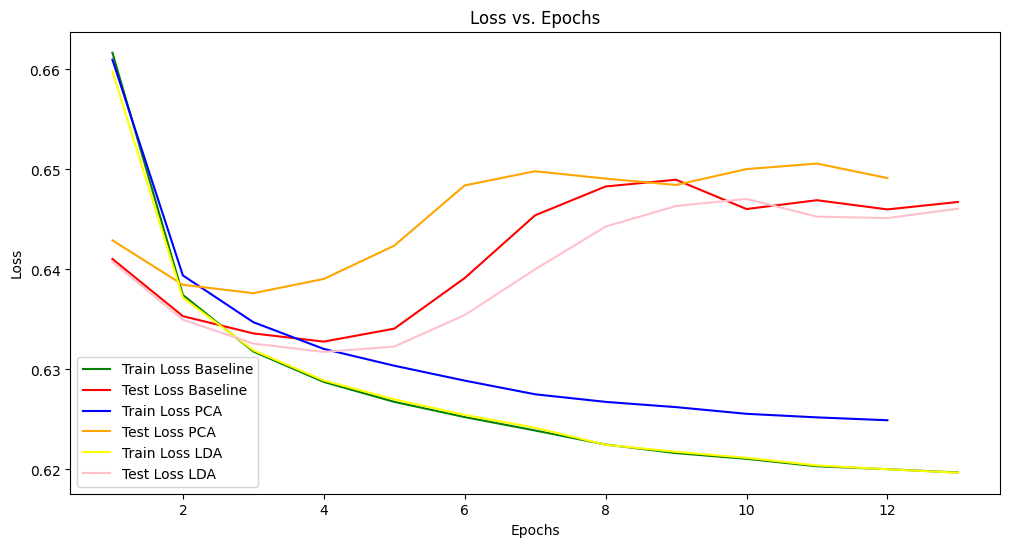

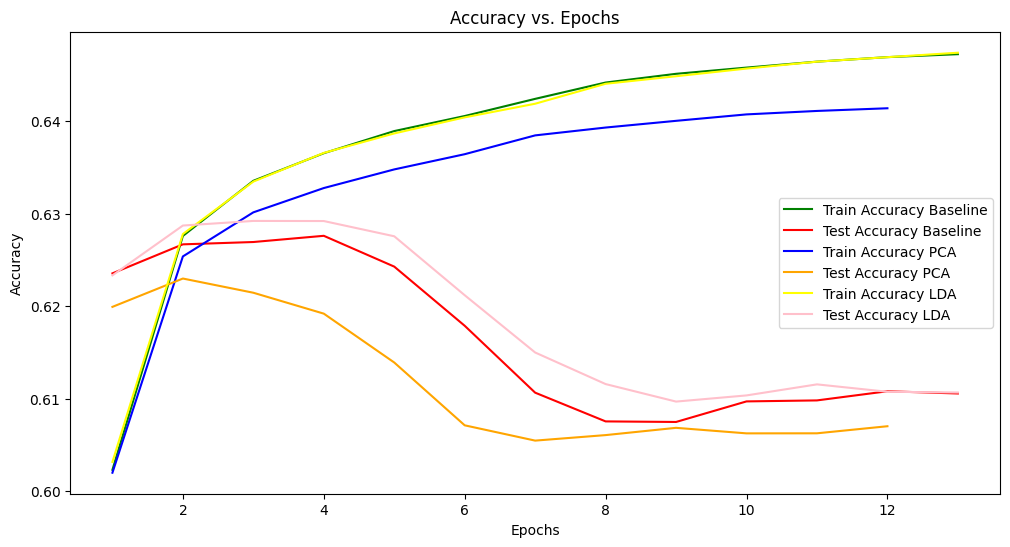

In [15]:
import matplotlib.pyplot as plt
import numpy as np


# Plotting function
plt.figure(figsize=(12, 6))
plt.plot(np.arange(1, len(train_loss) + 1), train_loss, label='Train Loss Baseline', color='green')
plt.plot(np.arange(1, len(test_loss) + 1), test_loss, label='Test Loss Baseline', color='red')
plt.plot(np.arange(1, len(train_loss_pca) + 1), train_loss_pca, label='Train Loss PCA', color='blue')
plt.plot(np.arange(1, len(test_loss_pca) + 1), test_loss_pca, label='Test Loss PCA', color='orange')
plt.plot(np.arange(1, len(train_loss_lda) + 1), train_loss_lda, label='Train Loss LDA', color='yellow')
plt.plot(np.arange(1, len(test_loss_lda) + 1), test_loss_lda, label='Test Loss LDA', color='pink')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs. Epochs')
plt.legend()
plt.show()

# Plotting function for accuracy
plt.figure(figsize=(12, 6))
plt.plot(np.arange(1, len(train_accuracy) + 1), train_accuracy, label='Train Accuracy Baseline', color='green')
plt.plot(np.arange(1, len(test_accuracy) + 1), test_accuracy, label='Test Accuracy Baseline', color='red')
plt.plot(np.arange(1, len(train_accuracy_pca) + 1), train_accuracy_pca, label='Train Accuracy PCA', color='blue')   
plt.plot(np.arange(1, len(test_accuracy_pca) + 1), test_accuracy_pca, label='Test Accuracy PCA', color='orange')
plt.plot(np.arange(1, len(train_accuracy_lda) + 1), train_accuracy_lda, label='Train Accuracy LDA', color='yellow')   
plt.plot(np.arange(1, len(test_accuracy_lda) + 1), test_accuracy_lda, label='Test Accuracy LDA', color='pink')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epochs')
plt.legend()
plt.show()

## Load Advanced Encodings

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from tqdm import tqdm
from torch.utils.data import DataLoader, TensorDataset
import helper_functions
import importlib
import os

train_dtypes=test_dtypes=dtypes = {
    'ProductName':                                                  'float32',
    'IsBeta':                                                       'float32',
    'RtpStateBitfield':                                             'float32',
    'IsSxsPassiveMode':                                             'float32',
    'DefaultBrowsersIdentifier':                                    'float32',
    'AVProductStatesIdentifier':                                    'float32',
    'AVProductsInstalled':                                          'float32',
    'AVProductsEnabled':                                            'float32',
    'HasTpm':                                                       'float32',
    'CountryIdentifier':                                            'float32',
    'CityIdentifier':                                               'float32',
    'OrganizationIdentifier':                                       'float32',
    'GeoNameIdentifier':                                            'float32',
    'LocaleEnglishNameIdentifier':                                  'float32',
    'Platform':                                                     'float32',
    'Processor':                                                    'float32',
    'OsVer':                                                        'float32',
    'OsBuild':                                                      'float32',
    'OsSuite':                                                      'float32',
    'OsPlatformSubRelease':                                         'float32',
    'OsBuildLab':                                                   'float32',
    'SkuEdition':                                                   'float32',
    'IsProtected':                                                  'float32',
    'AutoSampleOptIn':                                              'float32',
    'PuaMode':                                                      'float32',
    'SMode':                                                        'float32',
    'IeVerIdentifier':                                              'float32',
    'SmartScreen':                                                  'float32',
    'Firewall':                                                     'float32',
    'UacLuaenable':                                                 'float32',
    'Census_MDC2FormFactor':                                        'float32',
    'Census_DeviceFamily':                                          'float32',
    'Census_OEMNameIdentifier':                                     'float32',
    'Census_OEMModelIdentifier':                                    'float32',
    'Census_ProcessorCoreCount':                                    'float32',
    'Census_ProcessorManufacturerIdentifier':                       'float32',
    'Census_ProcessorModelIdentifier':                              'float32',
    'Census_ProcessorClass':                                        'float32',
    'Census_PrimaryDiskTotalCapacity':                              'float32',
    'Census_PrimaryDiskTypeName':                                   'float32',
    'Census_SystemVolumeTotalCapacity':                             'float32',
    'Census_HasOpticalDiskDrive':                                   'float32',
    'Census_TotalPhysicalRAM':                                      'float32',
    'Census_ChassisTypeName':                                       'float32',
    'Census_InternalPrimaryDiagonalDisplaySizeInInches':            'float32',
    'Census_InternalPrimaryDisplayResolutionHorizontal':            'float32',
    'Census_InternalPrimaryDisplayResolutionVertical':              'float32',
    'Census_PowerPlatformRoleName':                                 'float32',
    'Census_InternalBatteryType':                                   'float32',
    'Census_InternalBatteryNumberOfCharges':                        'float32',
    'Census_OSArchitecture':                                        'float32',
    'Census_OSBranch':                                              'float32',
    'Census_OSBuildNumber':                                         'float32',
    'Census_OSBuildRevision':                                       'float32',
    'Census_OSEdition':                                             'float32',
    'Census_OSSkuName':                                             'float32',
    'Census_OSInstallTypeName':                                     'float32',
    'Census_OSInstallLanguageIdentifier':                           'float32',
    'Census_OSUILocaleIdentifier':                                  'float32',
    'Census_OSWUAutoUpdateOptionsName':                             'float32',
    'Census_IsPortableOperatingSystem':                             'float32',
    'Census_GenuineStateName':                                      'float32',
    'Census_ActivationChannel':                                     'float32',
    'Census_IsFlightingInternal':                                   'float32',
    'Census_IsFlightsDisabled':                                     'float32',
    'Census_FlightRing':                                            'float32',
    'Census_ThresholdOptIn':                                        'float32',
    'Census_FirmwareManufacturerIdentifier':                        'float32',
    'Census_FirmwareVersionIdentifier':                             'float32',
    'Census_IsSecureBootEnabled':                                   'float32',
    'Census_IsWIMBootEnabled':                                      'float32',
    'Census_IsVirtualDevice':                                       'float32',
    'Census_IsTouchEnabled':                                        'float32',
    'Census_IsPenCapable':                                          'float32',
    'Census_IsAlwaysOnAlwaysConnectedCapable':                      'float32',
    'Wdft_IsGamer':                                                 'float32',
    'Wdft_RegionIdentifier':                                        'float32',
    'EngineVersion_1':                                              'int8',
    'EngineVersion_2':                                              'int8',
    'EngineVersion_3':                                              'float32',
    'EngineVersion_4':                                              'float32',
    'AppVersion_1':                                                 'int8',
    'AppVersion_2':                                                 'float32',
    'AppVersion_3':                                                 'float32',
    'AppVersion_4':                                                 'float32',
    'AvSigVersion_1':                                               'float32',
    'AvSigVersion_2':                                               'float32',
    'AvSigVersion_3':                                               'float32',
    'AvSigVersion_4':                                               'int8',
    'Census_OSVersion_1':                                           'float32',
    'Census_OSVersion_2':                                           'float32',
    'Census_OSVersion_3':                                           'float32',
    'Census_OSVersion_4':                                           'float32',
    'HasDetections':                                                'int8',
}
# Load the encoded datasets
train_data = pd.read_csv("../data/train_data_kaggle_processed.csv",dtype=train_dtypes)
test_data = pd.read_csv("../data/validation_data_kaggle_processed.csv",dtype=test_dtypes)

X_train = train_data.drop('HasDetections', axis=1)
y_train = train_data['HasDetections']
X_valid = test_data.drop('HasDetections', axis=1)
y_valid = test_data['HasDetections']

del train_data, test_data

## Train 3-Hidden-Layer Neural Network (Regular)

In [ ]:
X_train_kagenc_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_kagenc_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_valid_kagenc_tensor = torch.tensor(X_valid.values, dtype=torch.float32)
y_valid_kagenc_tensor = torch.tensor(y_valid.values, dtype=torch.float32).view(-1, 1)


# Figure out which device to use. By default, CPU
device = "cpu"
# For M-architecture Macs
if torch.backends.mps.is_available():
    device = torch.device("mps")
# For NVIDIA
elif torch.cuda.is_available():
    device = torch.device("cuda")

# DataLoader
train_dataset_kagenc = TensorDataset(X_train_kagenc_tensor, y_train_kagenc_tensor)
valid_dataset_kagenc = TensorDataset(X_valid_kagenc_tensor, y_valid_kagenc_tensor)

batch_size = 2048
train_loader_kagenc = DataLoader(train_dataset_kagenc, batch_size=batch_size, shuffle=True)
test_loader_kagenc = DataLoader(valid_dataset_kagenc, batch_size=batch_size, shuffle=False)

# Model
# Define complex model
class BinaryClassifier(nn.Module):
    def __init__(self):
        super(BinaryClassifier, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(X_train_kagenc_tensor.shape[1], 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.3),

            nn.Linear(512, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.3),

            nn.Linear(256, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.4),

            nn.Linear(128, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.4),

            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.layers(x)



model_kagenc = BinaryClassifier().to(device)

criterion = nn.BCEWithLogitsLoss()  # or use nn.BCEWithLogitsLoss and remove sigmoid
optimizer = optim.Adam(model_kagenc.parameters(), weight_decay=1e-4, lr=0.0001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

epochs = 100
# Train
best_model_weights_kagenc, train_loss_kagenc, test_loss_kagenc, train_accuracy_kagenc, test_accuracy_kagenc, lrs_kagenc = helper_functions.train_and_evaluate_model(
    model_kagenc, criterion, optimizer, scheduler, train_loader_kagenc, test_loader_kagenc, epochs=epochs
)

torch.save(model_kagenc.state_dict(), '../Saved Models/3hl_advanced_encodings.pth')

Training on mps


Epoch 1/100 - LR: 0.000100: 100%|█████████████████████████████| 3485/3485 [02:18<00:00, 25.17it/s, acc=63.06%, loss=0.6315]


Epoch 1 Loss: 0.6632, Train Accuracy: 60.20%
Test Loss: 0.6362, Test Accuracy: 63.01%


Epoch 2/100 - LR: 0.000100: 100%|█████████████████████████████| 3485/3485 [02:15<00:00, 25.70it/s, acc=62.80%, loss=0.6297]


Epoch 2 Loss: 0.6371, Train Accuracy: 62.87%
Test Loss: 0.6276, Test Accuracy: 63.71%


Epoch 3/100 - LR: 0.000100: 100%|█████████████████████████████| 3485/3485 [02:16<00:00, 25.44it/s, acc=63.47%, loss=0.6338]


Epoch 3 Loss: 0.6309, Train Accuracy: 63.48%
Test Loss: 0.6245, Test Accuracy: 64.04%


Epoch 4/100 - LR: 0.000100: 100%|█████████████████████████████| 3485/3485 [02:16<00:00, 25.58it/s, acc=63.88%, loss=0.6299]


Epoch 4 Loss: 0.6281, Train Accuracy: 63.78%
Test Loss: 0.6228, Test Accuracy: 64.24%


Epoch 5/100 - LR: 0.000100: 100%|█████████████████████████████| 3485/3485 [02:16<00:00, 25.49it/s, acc=64.96%, loss=0.6231]


Epoch 5 Loss: 0.6264, Train Accuracy: 63.96%
Test Loss: 0.6215, Test Accuracy: 64.39%


Epoch 6/100 - LR: 0.000100: 100%|█████████████████████████████| 3485/3485 [02:16<00:00, 25.56it/s, acc=62.29%, loss=0.6307]


Epoch 6 Loss: 0.6251, Train Accuracy: 64.12%
Test Loss: 0.6204, Test Accuracy: 64.57%


Epoch 7/100 - LR: 0.000100: 100%|█████████████████████████████| 3485/3485 [02:16<00:00, 25.47it/s, acc=64.85%, loss=0.6208]


Epoch 7 Loss: 0.6237, Train Accuracy: 64.30%
Test Loss: 0.6189, Test Accuracy: 64.74%


Epoch 8/100 - LR: 0.000100: 100%|█████████████████████████████| 3485/3485 [02:16<00:00, 25.55it/s, acc=63.67%, loss=0.6265]


Epoch 8 Loss: 0.6224, Train Accuracy: 64.48%
Test Loss: 0.6179, Test Accuracy: 64.87%


Epoch 9/100 - LR: 0.000100: 100%|█████████████████████████████| 3485/3485 [02:17<00:00, 25.38it/s, acc=63.57%, loss=0.6312]


Epoch 9 Loss: 0.6215, Train Accuracy: 64.57%
Test Loss: 0.6171, Test Accuracy: 64.97%


Epoch 10/100 - LR: 0.000100: 100%|████████████████████████████| 3485/3485 [02:16<00:00, 25.56it/s, acc=62.24%, loss=0.6318]


Epoch 10 Loss: 0.6206, Train Accuracy: 64.68%
Test Loss: 0.6164, Test Accuracy: 65.04%


Epoch 11/100 - LR: 0.000100: 100%|████████████████████████████| 3485/3485 [02:16<00:00, 25.55it/s, acc=64.85%, loss=0.6229]


Epoch 11 Loss: 0.6199, Train Accuracy: 64.74%
Test Loss: 0.6158, Test Accuracy: 65.08%


Epoch 12/100 - LR: 0.000100: 100%|████████████████████████████| 3485/3485 [02:16<00:00, 25.47it/s, acc=63.47%, loss=0.6296]


Epoch 12 Loss: 0.6193, Train Accuracy: 64.80%
Test Loss: 0.6154, Test Accuracy: 65.14%


Epoch 13/100 - LR: 0.000100: 100%|████████████████████████████| 3485/3485 [02:16<00:00, 25.48it/s, acc=65.52%, loss=0.6246]


Epoch 13 Loss: 0.6188, Train Accuracy: 64.87%
Test Loss: 0.6147, Test Accuracy: 65.19%


Epoch 14/100 - LR: 0.000100: 100%|████████████████████████████| 3485/3485 [02:17<00:00, 25.43it/s, acc=65.37%, loss=0.6082]


Epoch 14 Loss: 0.6182, Train Accuracy: 64.94%
Test Loss: 0.6142, Test Accuracy: 65.24%


Epoch 15/100 - LR: 0.000100: 100%|████████████████████████████| 3485/3485 [02:16<00:00, 25.51it/s, acc=64.08%, loss=0.6187]


Epoch 15 Loss: 0.6179, Train Accuracy: 64.97%
Test Loss: 0.6140, Test Accuracy: 65.30%


Epoch 16/100 - LR: 0.000100: 100%|████████████████████████████| 3485/3485 [02:17<00:00, 25.43it/s, acc=65.16%, loss=0.6220]


Epoch 16 Loss: 0.6174, Train Accuracy: 65.01%
Test Loss: 0.6134, Test Accuracy: 65.36%


Epoch 17/100 - LR: 0.000100: 100%|████████████████████████████| 3485/3485 [02:16<00:00, 25.53it/s, acc=65.37%, loss=0.6133]


Epoch 17 Loss: 0.6171, Train Accuracy: 65.04%
Test Loss: 0.6133, Test Accuracy: 65.36%


Epoch 18/100 - LR: 0.000100: 100%|████████████████████████████| 3485/3485 [02:17<00:00, 25.41it/s, acc=67.62%, loss=0.6081]


Epoch 18 Loss: 0.6169, Train Accuracy: 65.08%
Test Loss: 0.6131, Test Accuracy: 65.40%


Epoch 19/100 - LR: 0.000100: 100%|████████████████████████████| 3485/3485 [02:16<00:00, 25.44it/s, acc=64.60%, loss=0.6172]


Epoch 19 Loss: 0.6165, Train Accuracy: 65.12%
Test Loss: 0.6123, Test Accuracy: 65.43%


Epoch 20/100 - LR: 0.000100: 100%|████████████████████████████| 3485/3485 [02:17<00:00, 25.35it/s, acc=63.57%, loss=0.6178]


Epoch 20 Loss: 0.6163, Train Accuracy: 65.13%
Test Loss: 0.6123, Test Accuracy: 65.46%


Epoch 21/100 - LR: 0.000100: 100%|████████████████████████████| 3485/3485 [02:15<00:00, 25.73it/s, acc=64.55%, loss=0.6177]


Epoch 21 Loss: 0.6160, Train Accuracy: 65.15%
Test Loss: 0.6124, Test Accuracy: 65.45%


Epoch 22/100 - LR: 0.000100: 100%|████████████████████████████| 3485/3485 [02:15<00:00, 25.68it/s, acc=64.75%, loss=0.6216]


Epoch 22 Loss: 0.6158, Train Accuracy: 65.19%
Test Loss: 0.6122, Test Accuracy: 65.49%


Epoch 23/100 - LR: 0.000100: 100%|████████████████████████████| 3485/3485 [02:15<00:00, 25.70it/s, acc=65.06%, loss=0.6237]


Epoch 23 Loss: 0.6156, Train Accuracy: 65.22%
Test Loss: 0.6116, Test Accuracy: 65.55%


Epoch 24/100 - LR: 0.000100: 100%|████████████████████████████| 3485/3485 [02:15<00:00, 25.69it/s, acc=65.78%, loss=0.6120]


Epoch 24 Loss: 0.6154, Train Accuracy: 65.24%
Test Loss: 0.6113, Test Accuracy: 65.58%


Epoch 25/100 - LR: 0.000100: 100%|████████████████████████████| 3485/3485 [02:15<00:00, 25.74it/s, acc=65.73%, loss=0.6083]


Epoch 25 Loss: 0.6152, Train Accuracy: 65.26%
Test Loss: 0.6113, Test Accuracy: 65.59%


Epoch 26/100 - LR: 0.000100: 100%|████████████████████████████| 3485/3485 [02:15<00:00, 25.69it/s, acc=65.67%, loss=0.6168]


Epoch 26 Loss: 0.6150, Train Accuracy: 65.27%
Test Loss: 0.6111, Test Accuracy: 65.59%


Epoch 27/100 - LR: 0.000100: 100%|████████████████████████████| 3485/3485 [02:15<00:00, 25.66it/s, acc=65.67%, loss=0.6131]


Epoch 27 Loss: 0.6149, Train Accuracy: 65.28%
Test Loss: 0.6112, Test Accuracy: 65.59%


Epoch 28/100 - LR: 0.000100: 100%|████████████████████████████| 3485/3485 [02:15<00:00, 25.75it/s, acc=64.91%, loss=0.6137]


Epoch 28 Loss: 0.6147, Train Accuracy: 65.31%
Test Loss: 0.6113, Test Accuracy: 65.57%


Epoch 29/100 - LR: 0.000100: 100%|████████████████████████████| 3485/3485 [02:15<00:00, 25.70it/s, acc=64.34%, loss=0.6279]


Epoch 29 Loss: 0.6145, Train Accuracy: 65.34%
Test Loss: 0.6107, Test Accuracy: 65.65%


Epoch 30/100 - LR: 0.000100: 100%|████████████████████████████| 3485/3485 [02:15<00:00, 25.74it/s, acc=65.42%, loss=0.6162]


Epoch 30 Loss: 0.6144, Train Accuracy: 65.35%
Test Loss: 0.6105, Test Accuracy: 65.65%


Epoch 31/100 - LR: 0.000100: 100%|████████████████████████████| 3485/3485 [02:15<00:00, 25.72it/s, acc=65.78%, loss=0.6106]


Epoch 31 Loss: 0.6142, Train Accuracy: 65.37%
Test Loss: 0.6104, Test Accuracy: 65.66%


Epoch 32/100 - LR: 0.000100: 100%|████████████████████████████| 3485/3485 [02:15<00:00, 25.77it/s, acc=66.60%, loss=0.6064]


Epoch 32 Loss: 0.6141, Train Accuracy: 65.37%
Test Loss: 0.6104, Test Accuracy: 65.68%


Epoch 33/100 - LR: 0.000100: 100%|████████████████████████████| 3485/3485 [02:15<00:00, 25.68it/s, acc=64.60%, loss=0.6143]


Epoch 33 Loss: 0.6140, Train Accuracy: 65.38%
Test Loss: 0.6100, Test Accuracy: 65.69%


Epoch 34/100 - LR: 0.000100: 100%|████████████████████████████| 3485/3485 [02:15<00:00, 25.66it/s, acc=64.29%, loss=0.6122]


Epoch 34 Loss: 0.6139, Train Accuracy: 65.39%
Test Loss: 0.6100, Test Accuracy: 65.73%


Epoch 35/100 - LR: 0.000100: 100%|████████████████████████████| 3485/3485 [02:16<00:00, 25.62it/s, acc=64.80%, loss=0.6221]


Epoch 35 Loss: 0.6138, Train Accuracy: 65.42%
Test Loss: 0.6099, Test Accuracy: 65.71%


Epoch 36/100 - LR: 0.000100: 100%|████████████████████████████| 3485/3485 [02:16<00:00, 25.53it/s, acc=64.55%, loss=0.6156]


Epoch 36 Loss: 0.6137, Train Accuracy: 65.43%
Test Loss: 0.6100, Test Accuracy: 65.70%


Epoch 37/100 - LR: 0.000100: 100%|████████████████████████████| 3485/3485 [02:15<00:00, 25.69it/s, acc=63.01%, loss=0.6269]


Epoch 37 Loss: 0.6136, Train Accuracy: 65.42%
Test Loss: 0.6098, Test Accuracy: 65.73%


Epoch 38/100 - LR: 0.000100: 100%|████████████████████████████| 3485/3485 [02:15<00:00, 25.67it/s, acc=65.93%, loss=0.6061]


Epoch 38 Loss: 0.6135, Train Accuracy: 65.46%
Test Loss: 0.6096, Test Accuracy: 65.75%


Epoch 39/100 - LR: 0.000100: 100%|████████████████████████████| 3485/3485 [02:15<00:00, 25.74it/s, acc=67.62%, loss=0.5993]


Epoch 39 Loss: 0.6134, Train Accuracy: 65.46%
Test Loss: 0.6098, Test Accuracy: 65.77%


Epoch 40/100 - LR: 0.000100: 100%|████████████████████████████| 3485/3485 [02:16<00:00, 25.56it/s, acc=64.60%, loss=0.6300]


Epoch 40 Loss: 0.6132, Train Accuracy: 65.48%
Test Loss: 0.6095, Test Accuracy: 65.79%


Epoch 41/100 - LR: 0.000100: 100%|████████████████████████████| 3485/3485 [02:16<00:00, 25.61it/s, acc=65.88%, loss=0.6154]


Epoch 41 Loss: 0.6133, Train Accuracy: 65.47%
Test Loss: 0.6093, Test Accuracy: 65.77%


Epoch 42/100 - LR: 0.000100: 100%|████████████████████████████| 3485/3485 [02:16<00:00, 25.54it/s, acc=63.98%, loss=0.6142]


Epoch 42 Loss: 0.6131, Train Accuracy: 65.47%
Test Loss: 0.6094, Test Accuracy: 65.78%


Epoch 43/100 - LR: 0.000100: 100%|████████████████████████████| 3485/3485 [02:15<00:00, 25.69it/s, acc=64.70%, loss=0.6161]


Epoch 43 Loss: 0.6131, Train Accuracy: 65.49%
Test Loss: 0.6093, Test Accuracy: 65.78%


Epoch 44/100 - LR: 0.000100: 100%|████████████████████████████| 3485/3485 [02:16<00:00, 25.62it/s, acc=65.42%, loss=0.6091]


Epoch 44 Loss: 0.6130, Train Accuracy: 65.48%
Test Loss: 0.6091, Test Accuracy: 65.82%


Epoch 45/100 - LR: 0.000100: 100%|████████████████████████████| 3485/3485 [02:17<00:00, 25.43it/s, acc=66.03%, loss=0.6148]


Epoch 45 Loss: 0.6129, Train Accuracy: 65.50%
Test Loss: 0.6091, Test Accuracy: 65.81%


Epoch 46/100 - LR: 0.000100: 100%|████████████████████████████| 3485/3485 [02:16<00:00, 25.47it/s, acc=65.83%, loss=0.6212]


Epoch 46 Loss: 0.6128, Train Accuracy: 65.51%
Test Loss: 0.6090, Test Accuracy: 65.81%


Epoch 47/100 - LR: 0.000100: 100%|████████████████████████████| 3485/3485 [02:17<00:00, 25.40it/s, acc=66.80%, loss=0.6108]


Epoch 47 Loss: 0.6127, Train Accuracy: 65.51%
Test Loss: 0.6089, Test Accuracy: 65.80%


Epoch 48/100 - LR: 0.000100: 100%|████████████████████████████| 3485/3485 [02:16<00:00, 25.45it/s, acc=64.39%, loss=0.6262]


Epoch 48 Loss: 0.6127, Train Accuracy: 65.54%
Test Loss: 0.6088, Test Accuracy: 65.82%


Epoch 49/100 - LR: 0.000100: 100%|████████████████████████████| 3485/3485 [02:17<00:00, 25.43it/s, acc=66.29%, loss=0.6001]


Epoch 49 Loss: 0.6126, Train Accuracy: 65.53%
Test Loss: 0.6090, Test Accuracy: 65.81%


Epoch 50/100 - LR: 0.000100: 100%|████████████████████████████| 3485/3485 [02:16<00:00, 25.54it/s, acc=65.16%, loss=0.6108]


Epoch 50 Loss: 0.6126, Train Accuracy: 65.54%
Test Loss: 0.6087, Test Accuracy: 65.81%


Epoch 51/100 - LR: 0.000100: 100%|████████████████████████████| 3485/3485 [02:16<00:00, 25.61it/s, acc=64.39%, loss=0.6179]


Epoch 51 Loss: 0.6124, Train Accuracy: 65.55%
Test Loss: 0.6087, Test Accuracy: 65.81%


Epoch 52/100 - LR: 0.000100: 100%|████████████████████████████| 3485/3485 [02:14<00:00, 25.83it/s, acc=64.91%, loss=0.6175]


Epoch 52 Loss: 0.6124, Train Accuracy: 65.56%
Test Loss: 0.6087, Test Accuracy: 65.85%


Epoch 53/100 - LR: 0.000100: 100%|████████████████████████████| 3485/3485 [02:16<00:00, 25.55it/s, acc=66.44%, loss=0.6111]


Epoch 53 Loss: 0.6125, Train Accuracy: 65.55%
Test Loss: 0.6087, Test Accuracy: 65.83%
Learning rate changed from 0.000100 to 0.000050


Epoch 54/100 - LR: 0.000050: 100%|████████████████████████████| 3485/3485 [02:15<00:00, 25.65it/s, acc=66.39%, loss=0.6072]


Epoch 54 Loss: 0.6112, Train Accuracy: 65.68%
Test Loss: 0.6074, Test Accuracy: 65.96%


Epoch 55/100 - LR: 0.000050: 100%|████████████████████████████| 3485/3485 [02:16<00:00, 25.62it/s, acc=65.62%, loss=0.6106]


Epoch 55 Loss: 0.6107, Train Accuracy: 65.73%
Test Loss: 0.6072, Test Accuracy: 66.00%


Epoch 56/100 - LR: 0.000050: 100%|████████████████████████████| 3485/3485 [02:17<00:00, 25.42it/s, acc=65.67%, loss=0.6101]


Epoch 56 Loss: 0.6106, Train Accuracy: 65.73%
Test Loss: 0.6071, Test Accuracy: 65.99%


Epoch 57/100 - LR: 0.000050: 100%|████████████████████████████| 3485/3485 [02:17<00:00, 25.44it/s, acc=67.62%, loss=0.6049]


Epoch 57 Loss: 0.6105, Train Accuracy: 65.75%
Test Loss: 0.6069, Test Accuracy: 66.03%


Epoch 58/100 - LR: 0.000050: 100%|████████████████████████████| 3485/3485 [02:17<00:00, 25.41it/s, acc=65.62%, loss=0.6197]


Epoch 58 Loss: 0.6103, Train Accuracy: 65.75%
Test Loss: 0.6088, Test Accuracy: 65.87%


Epoch 59/100 - LR: 0.000050: 100%|████████████████████████████| 3485/3485 [02:16<00:00, 25.45it/s, acc=66.60%, loss=0.6022]


Epoch 59 Loss: 0.6103, Train Accuracy: 65.77%
Test Loss: 0.6070, Test Accuracy: 66.01%


Epoch 60/100 - LR: 0.000050: 100%|████████████████████████████| 3485/3485 [02:16<00:00, 25.47it/s, acc=66.96%, loss=0.6054]


Epoch 60 Loss: 0.6103, Train Accuracy: 65.76%
Test Loss: 0.6071, Test Accuracy: 66.01%
Learning rate changed from 0.000050 to 0.000025


Epoch 61/100 - LR: 0.000025: 100%|████████████████████████████| 3485/3485 [02:16<00:00, 25.48it/s, acc=65.78%, loss=0.6102]


Epoch 61 Loss: 0.6095, Train Accuracy: 65.83%
Test Loss: 0.6062, Test Accuracy: 66.07%


Epoch 62/100 - LR: 0.000025: 100%|████████████████████████████| 3485/3485 [02:17<00:00, 25.33it/s, acc=67.78%, loss=0.5924]


Epoch 62 Loss: 0.6093, Train Accuracy: 65.86%
Test Loss: 0.6061, Test Accuracy: 66.09%


Epoch 63/100 - LR: 0.000025: 100%|████████████████████████████| 3485/3485 [02:17<00:00, 25.43it/s, acc=65.98%, loss=0.6046]


Epoch 63 Loss: 0.6091, Train Accuracy: 65.88%
Test Loss: 0.6062, Test Accuracy: 66.08%


Epoch 64/100 - LR: 0.000025: 100%|████████████████████████████| 3485/3485 [02:17<00:00, 25.43it/s, acc=65.93%, loss=0.6123]


Epoch 64 Loss: 0.6091, Train Accuracy: 65.88%
Test Loss: 0.6063, Test Accuracy: 66.06%


Epoch 65/100 - LR: 0.000025: 100%|████████████████████████████| 3485/3485 [02:16<00:00, 25.54it/s, acc=66.75%, loss=0.6060]


Epoch 65 Loss: 0.6090, Train Accuracy: 65.89%
Test Loss: 0.6061, Test Accuracy: 66.09%
Learning rate changed from 0.000025 to 0.000013


Epoch 66/100 - LR: 0.000013: 100%|████████████████████████████| 3485/3485 [02:16<00:00, 25.52it/s, acc=67.52%, loss=0.6033]


Epoch 66 Loss: 0.6086, Train Accuracy: 65.93%
Test Loss: 0.6059, Test Accuracy: 66.11%


Epoch 67/100 - LR: 0.000013: 100%|████████████████████████████| 3485/3485 [02:17<00:00, 25.37it/s, acc=66.24%, loss=0.6071]


Epoch 67 Loss: 0.6085, Train Accuracy: 65.94%
Test Loss: 0.6059, Test Accuracy: 66.13%


Epoch 68/100 - LR: 0.000013: 100%|████████████████████████████| 3485/3485 [02:17<00:00, 25.42it/s, acc=66.03%, loss=0.6101]


Epoch 68 Loss: 0.6083, Train Accuracy: 65.95%
Test Loss: 0.6057, Test Accuracy: 66.13%


Epoch 69/100 - LR: 0.000013: 100%|████████████████████████████| 3485/3485 [02:17<00:00, 25.37it/s, acc=65.26%, loss=0.6213]


Epoch 69 Loss: 0.6083, Train Accuracy: 65.96%
Test Loss: 0.6058, Test Accuracy: 66.13%


Epoch 70/100 - LR: 0.000013: 100%|████████████████████████████| 3485/3485 [02:16<00:00, 25.51it/s, acc=65.42%, loss=0.5992]


Epoch 70 Loss: 0.6083, Train Accuracy: 65.96%
Test Loss: 0.6058, Test Accuracy: 66.15%


Epoch 71/100 - LR: 0.000013: 100%|████████████████████████████| 3485/3485 [02:16<00:00, 25.45it/s, acc=67.47%, loss=0.6037]


Epoch 71 Loss: 0.6082, Train Accuracy: 65.96%
Test Loss: 0.6057, Test Accuracy: 66.14%
Learning rate changed from 0.000013 to 0.000006


Epoch 72/100 - LR: 0.000006: 100%|████████████████████████████| 3485/3485 [02:16<00:00, 25.49it/s, acc=66.14%, loss=0.6078]


Epoch 72 Loss: 0.6079, Train Accuracy: 66.00%
Test Loss: 0.6058, Test Accuracy: 66.14%


Epoch 73/100 - LR: 0.000006: 100%|████████████████████████████| 3485/3485 [02:17<00:00, 25.35it/s, acc=65.78%, loss=0.6056]


Epoch 73 Loss: 0.6079, Train Accuracy: 65.99%
Test Loss: 0.6057, Test Accuracy: 66.14%


Epoch 74/100 - LR: 0.000006: 100%|████████████████████████████| 3485/3485 [02:16<00:00, 25.53it/s, acc=66.80%, loss=0.6066]


Epoch 74 Loss: 0.6078, Train Accuracy: 66.01%
Test Loss: 0.6056, Test Accuracy: 66.15%


Epoch 75/100 - LR: 0.000006: 100%|████████████████████████████| 3485/3485 [02:16<00:00, 25.55it/s, acc=66.29%, loss=0.6046]


Epoch 75 Loss: 0.6078, Train Accuracy: 66.02%
Test Loss: 0.6056, Test Accuracy: 66.16%


Epoch 76/100 - LR: 0.000006: 100%|████████████████████████████| 3485/3485 [02:16<00:00, 25.55it/s, acc=65.93%, loss=0.6134]


Epoch 76 Loss: 0.6077, Train Accuracy: 66.02%
Test Loss: 0.6055, Test Accuracy: 66.17%


Epoch 77/100 - LR: 0.000006: 100%|████████████████████████████| 3485/3485 [02:16<00:00, 25.50it/s, acc=67.83%, loss=0.5926]


Epoch 77 Loss: 0.6079, Train Accuracy: 66.00%
Test Loss: 0.6055, Test Accuracy: 66.17%


Epoch 78/100 - LR: 0.000006: 100%|████████████████████████████| 3485/3485 [02:17<00:00, 25.43it/s, acc=67.37%, loss=0.5976]


Epoch 78 Loss: 0.6077, Train Accuracy: 66.00%
Test Loss: 0.6055, Test Accuracy: 66.15%


Epoch 79/100 - LR: 0.000006: 100%|████████████████████████████| 3485/3485 [02:17<00:00, 25.39it/s, acc=65.11%, loss=0.6069]


Epoch 79 Loss: 0.6078, Train Accuracy: 66.01%
Test Loss: 0.6055, Test Accuracy: 66.17%


Epoch 80/100 - LR: 0.000006: 100%|████████████████████████████| 3485/3485 [02:17<00:00, 25.36it/s, acc=67.37%, loss=0.5974]


Epoch 80 Loss: 0.6076, Train Accuracy: 66.02%
Test Loss: 0.6054, Test Accuracy: 66.17%
Learning rate changed from 0.000006 to 0.000003


Epoch 81/100 - LR: 0.000003: 100%|████████████████████████████| 3485/3485 [02:17<00:00, 25.39it/s, acc=66.70%, loss=0.6099]


Epoch 81 Loss: 0.6076, Train Accuracy: 66.02%
Test Loss: 0.6054, Test Accuracy: 66.17%


Epoch 82/100 - LR: 0.000003: 100%|████████████████████████████| 3485/3485 [02:17<00:00, 25.43it/s, acc=64.96%, loss=0.6039]


Epoch 82 Loss: 0.6076, Train Accuracy: 66.02%
Test Loss: 0.6055, Test Accuracy: 66.15%


Epoch 83/100 - LR: 0.000003: 100%|████████████████████████████| 3485/3485 [02:16<00:00, 25.51it/s, acc=64.55%, loss=0.6189]


Epoch 83 Loss: 0.6075, Train Accuracy: 66.03%
Test Loss: 0.6054, Test Accuracy: 66.17%
Learning rate changed from 0.000003 to 0.000002


Epoch 84/100 - LR: 0.000002: 100%|████████████████████████████| 3485/3485 [02:17<00:00, 25.41it/s, acc=65.73%, loss=0.6156]


Epoch 84 Loss: 0.6074, Train Accuracy: 66.05%
Test Loss: 0.6053, Test Accuracy: 66.18%


Epoch 85/100 - LR: 0.000002: 100%|████████████████████████████| 3485/3485 [02:16<00:00, 25.60it/s, acc=65.52%, loss=0.6074]


Epoch 85 Loss: 0.6074, Train Accuracy: 66.04%
Test Loss: 0.6054, Test Accuracy: 66.17%


Epoch 86/100 - LR: 0.000002: 100%|████████████████████████████| 3485/3485 [02:16<00:00, 25.59it/s, acc=67.78%, loss=0.5942]


Epoch 86 Loss: 0.6074, Train Accuracy: 66.04%
Test Loss: 0.6054, Test Accuracy: 66.17%


Epoch 87/100 - LR: 0.000002: 100%|████████████████████████████| 3485/3485 [02:15<00:00, 25.68it/s, acc=65.93%, loss=0.6067]


Epoch 87 Loss: 0.6074, Train Accuracy: 66.05%
Test Loss: 0.6054, Test Accuracy: 66.17%
Learning rate changed from 0.000002 to 0.000001


Epoch 88/100 - LR: 0.000001: 100%|████████████████████████████| 3485/3485 [02:15<00:00, 25.66it/s, acc=67.52%, loss=0.5952]


Epoch 88 Loss: 0.6073, Train Accuracy: 66.04%
Test Loss: 0.6053, Test Accuracy: 66.17%


Epoch 89/100 - LR: 0.000001: 100%|████████████████████████████| 3485/3485 [02:16<00:00, 25.58it/s, acc=64.60%, loss=0.6184]


Epoch 89 Loss: 0.6074, Train Accuracy: 66.02%
Test Loss: 0.6053, Test Accuracy: 66.18%


Epoch 90/100 - LR: 0.000001: 100%|████████████████████████████| 3485/3485 [02:16<00:00, 25.62it/s, acc=66.19%, loss=0.6052]


Epoch 90 Loss: 0.6074, Train Accuracy: 66.04%
Test Loss: 0.6053, Test Accuracy: 66.18%
Learning rate changed from 0.000001 to 0.000000


Epoch 91/100 - LR: 0.000000: 100%|████████████████████████████| 3485/3485 [02:16<00:00, 25.53it/s, acc=67.16%, loss=0.6110]


Epoch 91 Loss: 0.6073, Train Accuracy: 66.05%
Test Loss: 0.6053, Test Accuracy: 66.19%


Epoch 92/100 - LR: 0.000000: 100%|████████████████████████████| 3485/3485 [02:15<00:00, 25.67it/s, acc=65.83%, loss=0.6071]


Epoch 92 Loss: 0.6073, Train Accuracy: 66.05%
Test Loss: 0.6054, Test Accuracy: 66.17%


Epoch 93/100 - LR: 0.000000: 100%|████████████████████████████| 3485/3485 [02:16<00:00, 25.53it/s, acc=67.16%, loss=0.5963]


Epoch 93 Loss: 0.6073, Train Accuracy: 66.05%
Test Loss: 0.6053, Test Accuracy: 66.18%
Learning rate changed from 0.000000 to 0.000000


Epoch 94/100 - LR: 0.000000: 100%|████████████████████████████| 3485/3485 [02:15<00:00, 25.65it/s, acc=65.83%, loss=0.6123]


Epoch 94 Loss: 0.6074, Train Accuracy: 66.05%
Test Loss: 0.6053, Test Accuracy: 66.18%


Epoch 95/100 - LR: 0.000000: 100%|████████████████████████████| 3485/3485 [02:16<00:00, 25.62it/s, acc=65.37%, loss=0.6168]


Epoch 95 Loss: 0.6073, Train Accuracy: 66.06%
Test Loss: 0.6053, Test Accuracy: 66.17%


Epoch 96/100 - LR: 0.000000: 100%|████████████████████████████| 3485/3485 [02:16<00:00, 25.59it/s, acc=63.31%, loss=0.6172]


Epoch 96 Loss: 0.6073, Train Accuracy: 66.06%
Test Loss: 0.6054, Test Accuracy: 66.18%
Learning rate changed from 0.000000 to 0.000000


Epoch 97/100 - LR: 0.000000: 100%|████████████████████████████| 3485/3485 [02:16<00:00, 25.53it/s, acc=67.06%, loss=0.6116]


Epoch 97 Loss: 0.6073, Train Accuracy: 66.06%
Test Loss: 0.6054, Test Accuracy: 66.18%


Epoch 98/100 - LR: 0.000000: 100%|████████████████████████████| 3485/3485 [02:16<00:00, 25.62it/s, acc=65.26%, loss=0.6138]


Epoch 98 Loss: 0.6073, Train Accuracy: 66.06%
Test Loss: 0.6053, Test Accuracy: 66.17%


Epoch 99/100 - LR: 0.000000: 100%|████████████████████████████| 3485/3485 [02:15<00:00, 25.68it/s, acc=63.88%, loss=0.6308]


Epoch 99 Loss: 0.6073, Train Accuracy: 66.06%
Test Loss: 0.6053, Test Accuracy: 66.18%
Learning rate changed from 0.000000 to 0.000000
Early stopping triggered at epoch 99. Best model was from epoch 91.


## Train 3-Hidden-Layer Neural Network (PCA)

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from tqdm import tqdm
from torch.utils.data import DataLoader, TensorDataset
import helper_functions
import importlib
import os

# Make sure these exist
assert 'X_train' in locals() and 'y_train' in locals()

pca_features = [
    'Census_OSInstallLanguageIdentifier', 
    'OsPlatformSubRelease', 
    'Census_InternalPrimaryDisplayResolutionHorizontal', 
    'dpi', 
    'Census_InternalPrimaryDisplayResolutionVertical', 
    'CountryIdentifier', 
    'IsSxsPassiveMode', 
    'RtpStateBitfield', 
    'OrganizationIdentifier', 
    'CityIdentifier', 
    'GeoNameIdentifier', 
    'Census_InternalBatteryNumberOfCharges', 
    'AvSigVersion', 
    'Census_HasOpticalDiskDrive', 
    'Census_ChassisTypeName', 
    'Census_OSBranch', 
    'Screen_Area', 
    'Census_GenuineStateName', 
    'Census_OSBuildRevision', 
    'Census_IsVirtualDevice', 
    'magic_4', 
    'LocaleEnglishNameIdentifier', 
    'Census_FirmwareVersionIdentifier', 
    'Census_OEMModelIdentifier', 
    'Census_MDC2FormFactor', 
    'Census_OSWUAutoUpdateOptionsName', 
    'Wdft_RegionIdentifier', 
    'AppVersion', 
    'Wdft_IsGamer', 
    'Firewall', 
    'Census_ProcessorModelIdentifier', 
    'Census_TotalPhysicalRAM', 
    'Census_FlightRing', 
    'IeVerIdentifier', 
    'Census_OEMNameIdentifier', 
    'DefaultBrowsersIdentifier', 
    'primary_drive_c_ratio', 
    'Census_PowerPlatformRoleName', 
    'Census_ProcessorCoreCount', 
    'Census_FirmwareManufacturerIdentifier', 
    'AVProductStatesIdentifier', 
    'SmartScreen', 
    'Census_OSInstallTypeName',
    'Census_OSVersion', 
    'EngineVersion', 
    'aspect_ratio', 
    'IsProtected', 
    'AVProductsEnabled', 
    'Census_IsSecureBootEnabled', 
    'OsBuildLab', 
    'Processor', 
    'Census_ActivationChannel', 
    'OsBuild', 
    'Census_SystemVolumeTotalCapacity', 
    'Census_PrimaryDiskTypeName'
]

X_train_kagenc_pca_tensor = torch.tensor(X_train[pca_features].values, dtype=torch.float32)
X_valid_kagenc_pca_tensor = torch.tensor(X_valid[pca_features].values, dtype=torch.float32)
y_train_kagenc_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
y_valid_kagenc_tensor = torch.tensor(y_valid.values, dtype=torch.float32).view(-1, 1)


# Figure out which device to use. By default, CPU
device = "cpu"
# For M-architecture Macs
if torch.backends.mps.is_available():
    device = torch.device("mps")
# For NVIDIA
elif torch.cuda.is_available():
    device = torch.device("cuda")

# DataLoader
train_dataset_kagenc_pca = TensorDataset(X_train_kagenc_pca_tensor, y_train_kagenc_tensor)
valid_dataset_kagenc_pca = TensorDataset(X_valid_kagenc_pca_tensor, y_valid_kagenc_tensor)

batch_size = 2048
train_loader_kagenc_pca = DataLoader(train_dataset_kagenc_pca, batch_size=batch_size, shuffle=True)
test_loader_kagenc_pca = DataLoader(valid_dataset_kagenc_pca, batch_size=batch_size, shuffle=False)

# Model
# Define complex model
class BinaryClassifier(nn.Module):
    def __init__(self):
        super(BinaryClassifier, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(X_train_kagenc_pca_tensor.shape[1], 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.3),

            nn.Linear(512, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.3),

            nn.Linear(256, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.4),

            nn.Linear(128, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.4),

            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.layers(x)



model_kagenc_pca = BinaryClassifier().to(device)

criterion = nn.BCEWithLogitsLoss()  # or use nn.BCEWithLogitsLoss and remove sigmoid
optimizer = optim.Adam(model_kagenc_pca.parameters(), weight_decay=1e-4, lr=0.0001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

epochs = 100
# Train
best_model_weights_kagenc_pca, train_loss_kagenc_pca, test_loss_kagenc_pca, train_accuracy_kagenc_pca, test_accuracy_kagenc_pca, lrs_kagenc_pca = helper_functions.train_and_evaluate_model(
    model_kagenc_pca, criterion, optimizer, scheduler, train_loader_kagenc_pca, test_loader_kagenc_pca, epochs=epochs
)

torch.save(model_kagenc_pca.state_dict(), '../Saved Models/3hl_advanced_encodings_pca.pth')

Training on mps


Epoch 1/100 - LR: 0.000100: 100%|█████████████████████████████| 3485/3485 [02:18<00:00, 25.23it/s, acc=62.19%, loss=0.6406]


Epoch 1 Loss: 0.6632, Train Accuracy: 59.92%
Test Loss: 0.6365, Test Accuracy: 62.85%


Epoch 2/100 - LR: 0.000100: 100%|█████████████████████████████| 3485/3485 [02:16<00:00, 25.51it/s, acc=62.60%, loss=0.6361]


Epoch 2 Loss: 0.6385, Train Accuracy: 62.57%
Test Loss: 0.6291, Test Accuracy: 63.49%


Epoch 3/100 - LR: 0.000100: 100%|█████████████████████████████| 3485/3485 [02:16<00:00, 25.58it/s, acc=64.39%, loss=0.6258]


Epoch 3 Loss: 0.6327, Train Accuracy: 63.22%
Test Loss: 0.6261, Test Accuracy: 63.85%


Epoch 4/100 - LR: 0.000100: 100%|█████████████████████████████| 3485/3485 [02:16<00:00, 25.48it/s, acc=63.37%, loss=0.6312]


Epoch 4 Loss: 0.6299, Train Accuracy: 63.54%
Test Loss: 0.6242, Test Accuracy: 64.11%


Epoch 5/100 - LR: 0.000100: 100%|█████████████████████████████| 3485/3485 [02:16<00:00, 25.53it/s, acc=64.24%, loss=0.6276]


Epoch 5 Loss: 0.6281, Train Accuracy: 63.74%
Test Loss: 0.6229, Test Accuracy: 64.21%


Epoch 6/100 - LR: 0.000100: 100%|█████████████████████████████| 3485/3485 [02:17<00:00, 25.42it/s, acc=64.19%, loss=0.6267]


Epoch 6 Loss: 0.6266, Train Accuracy: 63.90%
Test Loss: 0.6218, Test Accuracy: 64.35%


Epoch 7/100 - LR: 0.000100: 100%|█████████████████████████████| 3485/3485 [02:16<00:00, 25.46it/s, acc=65.11%, loss=0.6233]


Epoch 7 Loss: 0.6256, Train Accuracy: 64.04%
Test Loss: 0.6209, Test Accuracy: 64.44%


Epoch 8/100 - LR: 0.000100: 100%|█████████████████████████████| 3485/3485 [02:16<00:00, 25.46it/s, acc=64.14%, loss=0.6264]


Epoch 8 Loss: 0.6244, Train Accuracy: 64.19%
Test Loss: 0.6199, Test Accuracy: 64.59%


Epoch 9/100 - LR: 0.000100: 100%|█████████████████████████████| 3485/3485 [02:16<00:00, 25.45it/s, acc=65.57%, loss=0.6218]


Epoch 9 Loss: 0.6234, Train Accuracy: 64.32%
Test Loss: 0.6190, Test Accuracy: 64.72%


Epoch 10/100 - LR: 0.000100: 100%|████████████████████████████| 3485/3485 [02:17<00:00, 25.37it/s, acc=64.80%, loss=0.6300]


Epoch 10 Loss: 0.6226, Train Accuracy: 64.43%
Test Loss: 0.6182, Test Accuracy: 64.78%


Epoch 11/100 - LR: 0.000100: 100%|████████████████████████████| 3485/3485 [02:17<00:00, 25.42it/s, acc=65.67%, loss=0.6138]


Epoch 11 Loss: 0.6217, Train Accuracy: 64.53%
Test Loss: 0.6173, Test Accuracy: 64.90%


Epoch 12/100 - LR: 0.000100: 100%|████████████████████████████| 3485/3485 [02:16<00:00, 25.58it/s, acc=64.65%, loss=0.6251]


Epoch 12 Loss: 0.6208, Train Accuracy: 64.63%
Test Loss: 0.6167, Test Accuracy: 64.99%


Epoch 13/100 - LR: 0.000100: 100%|████████████████████████████| 3485/3485 [02:16<00:00, 25.51it/s, acc=63.37%, loss=0.6180]


Epoch 13 Loss: 0.6202, Train Accuracy: 64.70%
Test Loss: 0.6161, Test Accuracy: 65.05%


Epoch 14/100 - LR: 0.000100: 100%|████████████████████████████| 3485/3485 [02:16<00:00, 25.53it/s, acc=64.65%, loss=0.6244]


Epoch 14 Loss: 0.6197, Train Accuracy: 64.74%
Test Loss: 0.6159, Test Accuracy: 65.06%


Epoch 15/100 - LR: 0.000100: 100%|████████████████████████████| 3485/3485 [02:16<00:00, 25.46it/s, acc=64.39%, loss=0.6176]


Epoch 15 Loss: 0.6193, Train Accuracy: 64.80%
Test Loss: 0.6153, Test Accuracy: 65.14%


Epoch 16/100 - LR: 0.000100: 100%|████████████████████████████| 3485/3485 [02:16<00:00, 25.46it/s, acc=65.32%, loss=0.6168]


Epoch 16 Loss: 0.6189, Train Accuracy: 64.85%
Test Loss: 0.6149, Test Accuracy: 65.17%


Epoch 17/100 - LR: 0.000100: 100%|████████████████████████████| 3485/3485 [02:15<00:00, 25.64it/s, acc=64.44%, loss=0.6126]


Epoch 17 Loss: 0.6185, Train Accuracy: 64.89%
Test Loss: 0.6145, Test Accuracy: 65.25%


Epoch 18/100 - LR: 0.000100: 100%|████████████████████████████| 3485/3485 [02:17<00:00, 25.25it/s, acc=64.65%, loss=0.6193]


Epoch 18 Loss: 0.6182, Train Accuracy: 64.92%
Test Loss: 0.6140, Test Accuracy: 65.28%


Epoch 19/100 - LR: 0.000100: 100%|████████████████████████████| 3485/3485 [02:17<00:00, 25.31it/s, acc=67.16%, loss=0.6058]


Epoch 19 Loss: 0.6178, Train Accuracy: 64.95%
Test Loss: 0.6140, Test Accuracy: 65.26%


Epoch 20/100 - LR: 0.000100: 100%|████████████████████████████| 3485/3485 [02:16<00:00, 25.60it/s, acc=64.29%, loss=0.6315]


Epoch 20 Loss: 0.6176, Train Accuracy: 64.98%
Test Loss: 0.6136, Test Accuracy: 65.34%


Epoch 21/100 - LR: 0.000100: 100%|████████████████████████████| 3485/3485 [02:16<00:00, 25.49it/s, acc=65.11%, loss=0.6168]


Epoch 21 Loss: 0.6173, Train Accuracy: 65.02%
Test Loss: 0.6132, Test Accuracy: 65.36%


Epoch 22/100 - LR: 0.000100: 100%|████████████████████████████| 3485/3485 [02:17<00:00, 25.41it/s, acc=64.49%, loss=0.6171]


Epoch 22 Loss: 0.6171, Train Accuracy: 65.04%
Test Loss: 0.6131, Test Accuracy: 65.37%


Epoch 23/100 - LR: 0.000100: 100%|████████████████████████████| 3485/3485 [02:16<00:00, 25.46it/s, acc=64.39%, loss=0.6217]


Epoch 23 Loss: 0.6168, Train Accuracy: 65.07%
Test Loss: 0.6127, Test Accuracy: 65.40%


Epoch 24/100 - LR: 0.000100: 100%|████████████████████████████| 3485/3485 [02:16<00:00, 25.49it/s, acc=66.09%, loss=0.6096]


Epoch 24 Loss: 0.6166, Train Accuracy: 65.09%
Test Loss: 0.6127, Test Accuracy: 65.43%


Epoch 25/100 - LR: 0.000100: 100%|████████████████████████████| 3485/3485 [02:16<00:00, 25.45it/s, acc=66.70%, loss=0.6001]


Epoch 25 Loss: 0.6164, Train Accuracy: 65.12%
Test Loss: 0.6127, Test Accuracy: 65.46%


Epoch 26/100 - LR: 0.000100: 100%|████████████████████████████| 3485/3485 [02:16<00:00, 25.51it/s, acc=66.34%, loss=0.6073]


Epoch 26 Loss: 0.6162, Train Accuracy: 65.13%
Test Loss: 0.6122, Test Accuracy: 65.47%


Epoch 27/100 - LR: 0.000100: 100%|████████████████████████████| 3485/3485 [02:17<00:00, 25.37it/s, acc=64.39%, loss=0.6122]


Epoch 27 Loss: 0.6161, Train Accuracy: 65.15%
Test Loss: 0.6122, Test Accuracy: 65.48%


Epoch 28/100 - LR: 0.000100: 100%|████████████████████████████| 3485/3485 [02:17<00:00, 25.43it/s, acc=64.34%, loss=0.6262]


Epoch 28 Loss: 0.6159, Train Accuracy: 65.17%
Test Loss: 0.6119, Test Accuracy: 65.46%


Epoch 29/100 - LR: 0.000100: 100%|████████████████████████████| 3485/3485 [02:16<00:00, 25.48it/s, acc=65.06%, loss=0.6120]


Epoch 29 Loss: 0.6158, Train Accuracy: 65.17%
Test Loss: 0.6118, Test Accuracy: 65.52%


Epoch 30/100 - LR: 0.000100: 100%|████████████████████████████| 3485/3485 [02:17<00:00, 25.31it/s, acc=63.93%, loss=0.6209]


Epoch 30 Loss: 0.6157, Train Accuracy: 65.20%
Test Loss: 0.6116, Test Accuracy: 65.51%


Epoch 31/100 - LR: 0.000100: 100%|████████████████████████████| 3485/3485 [02:16<00:00, 25.55it/s, acc=66.39%, loss=0.6066]


Epoch 31 Loss: 0.6155, Train Accuracy: 65.21%
Test Loss: 0.6115, Test Accuracy: 65.55%


Epoch 32/100 - LR: 0.000100: 100%|████████████████████████████| 3485/3485 [02:16<00:00, 25.45it/s, acc=63.88%, loss=0.6298]


Epoch 32 Loss: 0.6154, Train Accuracy: 65.23%
Test Loss: 0.6112, Test Accuracy: 65.58%


Epoch 33/100 - LR: 0.000100: 100%|████████████████████████████| 3485/3485 [02:17<00:00, 25.44it/s, acc=64.14%, loss=0.6259]


Epoch 33 Loss: 0.6152, Train Accuracy: 65.23%
Test Loss: 0.6114, Test Accuracy: 65.53%


Epoch 34/100 - LR: 0.000100: 100%|████████████████████████████| 3485/3485 [02:16<00:00, 25.50it/s, acc=66.34%, loss=0.6175]


Epoch 34 Loss: 0.6150, Train Accuracy: 65.25%
Test Loss: 0.6110, Test Accuracy: 65.62%


Epoch 35/100 - LR: 0.000100: 100%|████████████████████████████| 3485/3485 [02:16<00:00, 25.50it/s, acc=65.11%, loss=0.6205]


Epoch 35 Loss: 0.6150, Train Accuracy: 65.24%
Test Loss: 0.6110, Test Accuracy: 65.61%


Epoch 36/100 - LR: 0.000100: 100%|████████████████████████████| 3485/3485 [02:16<00:00, 25.50it/s, acc=66.70%, loss=0.5958]


Epoch 36 Loss: 0.6149, Train Accuracy: 65.28%
Test Loss: 0.6110, Test Accuracy: 65.60%


Epoch 37/100 - LR: 0.000100: 100%|████████████████████████████| 3485/3485 [02:16<00:00, 25.45it/s, acc=66.44%, loss=0.6209]


Epoch 37 Loss: 0.6149, Train Accuracy: 65.27%
Test Loss: 0.6107, Test Accuracy: 65.65%


Epoch 38/100 - LR: 0.000100: 100%|████████████████████████████| 3485/3485 [02:16<00:00, 25.46it/s, acc=64.08%, loss=0.6217]


Epoch 38 Loss: 0.6146, Train Accuracy: 65.29%
Test Loss: 0.6109, Test Accuracy: 65.65%


Epoch 39/100 - LR: 0.000100: 100%|████████████████████████████| 3485/3485 [02:16<00:00, 25.49it/s, acc=66.96%, loss=0.6059]


Epoch 39 Loss: 0.6145, Train Accuracy: 65.31%
Test Loss: 0.6106, Test Accuracy: 65.65%


Epoch 40/100 - LR: 0.000100: 100%|████████████████████████████| 3485/3485 [02:16<00:00, 25.46it/s, acc=64.91%, loss=0.6184]


Epoch 40 Loss: 0.6144, Train Accuracy: 65.32%
Test Loss: 0.6107, Test Accuracy: 65.67%


Epoch 41/100 - LR: 0.000100: 100%|████████████████████████████| 3485/3485 [02:16<00:00, 25.49it/s, acc=65.16%, loss=0.6120]


Epoch 41 Loss: 0.6142, Train Accuracy: 65.33%
Test Loss: 0.6107, Test Accuracy: 65.67%


Epoch 42/100 - LR: 0.000100: 100%|████████████████████████████| 3485/3485 [02:16<00:00, 25.50it/s, acc=66.34%, loss=0.6025]


Epoch 42 Loss: 0.6143, Train Accuracy: 65.34%
Test Loss: 0.6104, Test Accuracy: 65.67%


Epoch 43/100 - LR: 0.000100: 100%|████████████████████████████| 3485/3485 [02:17<00:00, 25.41it/s, acc=64.08%, loss=0.6173]


Epoch 43 Loss: 0.6142, Train Accuracy: 65.34%
Test Loss: 0.6101, Test Accuracy: 65.69%


Epoch 44/100 - LR: 0.000100: 100%|████████████████████████████| 3485/3485 [02:17<00:00, 25.37it/s, acc=64.14%, loss=0.6234]


Epoch 44 Loss: 0.6141, Train Accuracy: 65.35%
Test Loss: 0.6101, Test Accuracy: 65.68%


Epoch 45/100 - LR: 0.000100: 100%|████████████████████████████| 3485/3485 [02:17<00:00, 25.39it/s, acc=66.60%, loss=0.6031]


Epoch 45 Loss: 0.6141, Train Accuracy: 65.35%
Test Loss: 0.6103, Test Accuracy: 65.65%


Epoch 46/100 - LR: 0.000100: 100%|████████████████████████████| 3485/3485 [02:16<00:00, 25.58it/s, acc=65.32%, loss=0.6078]


Epoch 46 Loss: 0.6140, Train Accuracy: 65.36%
Test Loss: 0.6102, Test Accuracy: 65.67%
Learning rate changed from 0.000100 to 0.000050


Epoch 47/100 - LR: 0.000050: 100%|████████████████████████████| 3485/3485 [02:16<00:00, 25.47it/s, acc=65.88%, loss=0.6036]


Epoch 47 Loss: 0.6128, Train Accuracy: 65.48%
Test Loss: 0.6092, Test Accuracy: 65.79%


Epoch 48/100 - LR: 0.000050: 100%|████████████████████████████| 3485/3485 [02:17<00:00, 25.43it/s, acc=66.75%, loss=0.6012]


Epoch 48 Loss: 0.6124, Train Accuracy: 65.51%
Test Loss: 0.6090, Test Accuracy: 65.83%


Epoch 49/100 - LR: 0.000050: 100%|████████████████████████████| 3485/3485 [02:17<00:00, 25.38it/s, acc=64.65%, loss=0.6184]


Epoch 49 Loss: 0.6122, Train Accuracy: 65.53%
Test Loss: 0.6091, Test Accuracy: 65.82%


Epoch 50/100 - LR: 0.000050: 100%|████████████████████████████| 3485/3485 [02:18<00:00, 25.23it/s, acc=66.34%, loss=0.6072]


Epoch 50 Loss: 0.6121, Train Accuracy: 65.55%
Test Loss: 0.6091, Test Accuracy: 65.82%


Epoch 51/100 - LR: 0.000050: 100%|████████████████████████████| 3485/3485 [02:16<00:00, 25.53it/s, acc=65.67%, loss=0.6096]


Epoch 51 Loss: 0.6121, Train Accuracy: 65.56%
Test Loss: 0.6089, Test Accuracy: 65.84%


Epoch 52/100 - LR: 0.000050: 100%|████████████████████████████| 3485/3485 [02:16<00:00, 25.47it/s, acc=64.85%, loss=0.6106]


Epoch 52 Loss: 0.6119, Train Accuracy: 65.57%
Test Loss: 0.6088, Test Accuracy: 65.84%


Epoch 53/100 - LR: 0.000050: 100%|████████████████████████████| 3485/3485 [02:17<00:00, 25.43it/s, acc=64.08%, loss=0.6217]


Epoch 53 Loss: 0.6119, Train Accuracy: 65.58%
Test Loss: 0.6089, Test Accuracy: 65.84%


Epoch 54/100 - LR: 0.000050: 100%|████████████████████████████| 3485/3485 [02:16<00:00, 25.46it/s, acc=65.37%, loss=0.6158]


Epoch 54 Loss: 0.6119, Train Accuracy: 65.57%
Test Loss: 0.6087, Test Accuracy: 65.86%


Epoch 55/100 - LR: 0.000050: 100%|████████████████████████████| 3485/3485 [02:16<00:00, 25.47it/s, acc=67.01%, loss=0.6063]


Epoch 55 Loss: 0.6118, Train Accuracy: 65.59%
Test Loss: 0.6088, Test Accuracy: 65.84%
Learning rate changed from 0.000050 to 0.000025


Epoch 56/100 - LR: 0.000025: 100%|████████████████████████████| 3485/3485 [02:16<00:00, 25.47it/s, acc=65.88%, loss=0.6113]


Epoch 56 Loss: 0.6111, Train Accuracy: 65.66%
Test Loss: 0.6083, Test Accuracy: 65.90%


Epoch 57/100 - LR: 0.000025: 100%|████████████████████████████| 3485/3485 [02:18<00:00, 25.12it/s, acc=64.55%, loss=0.6175]


Epoch 57 Loss: 0.6108, Train Accuracy: 65.68%
Test Loss: 0.6082, Test Accuracy: 65.90%


Epoch 58/100 - LR: 0.000025: 100%|████████████████████████████| 3485/3485 [02:17<00:00, 25.43it/s, acc=65.57%, loss=0.6188]


Epoch 58 Loss: 0.6107, Train Accuracy: 65.69%
Test Loss: 0.6080, Test Accuracy: 65.92%


Epoch 59/100 - LR: 0.000025: 100%|████████████████████████████| 3485/3485 [02:16<00:00, 25.47it/s, acc=65.16%, loss=0.6224]


Epoch 59 Loss: 0.6107, Train Accuracy: 65.71%
Test Loss: 0.6080, Test Accuracy: 65.93%


Epoch 60/100 - LR: 0.000025: 100%|████████████████████████████| 3485/3485 [02:16<00:00, 25.44it/s, acc=65.01%, loss=0.6064]


Epoch 60 Loss: 0.6106, Train Accuracy: 65.71%
Test Loss: 0.6080, Test Accuracy: 65.93%


Epoch 61/100 - LR: 0.000025: 100%|████████████████████████████| 3485/3485 [02:16<00:00, 25.53it/s, acc=65.98%, loss=0.6034]


Epoch 61 Loss: 0.6105, Train Accuracy: 65.71%
Test Loss: 0.6080, Test Accuracy: 65.92%
Learning rate changed from 0.000025 to 0.000013


Epoch 62/100 - LR: 0.000013: 100%|████████████████████████████| 3485/3485 [02:16<00:00, 25.48it/s, acc=64.60%, loss=0.6212]


Epoch 62 Loss: 0.6102, Train Accuracy: 65.75%
Test Loss: 0.6079, Test Accuracy: 65.94%


Epoch 63/100 - LR: 0.000013: 100%|████████████████████████████| 3485/3485 [02:16<00:00, 25.47it/s, acc=65.21%, loss=0.6129]


Epoch 63 Loss: 0.6099, Train Accuracy: 65.76%
Test Loss: 0.6078, Test Accuracy: 65.95%


Epoch 64/100 - LR: 0.000013: 100%|████████████████████████████| 3485/3485 [02:16<00:00, 25.52it/s, acc=65.01%, loss=0.6137]


Epoch 64 Loss: 0.6099, Train Accuracy: 65.78%
Test Loss: 0.6078, Test Accuracy: 65.95%


Epoch 65/100 - LR: 0.000013: 100%|████████████████████████████| 3485/3485 [02:16<00:00, 25.50it/s, acc=64.80%, loss=0.6205]


Epoch 65 Loss: 0.6099, Train Accuracy: 65.78%
Test Loss: 0.6077, Test Accuracy: 65.96%


Epoch 66/100 - LR: 0.000013: 100%|████████████████████████████| 3485/3485 [02:17<00:00, 25.39it/s, acc=63.88%, loss=0.6199]


Epoch 66 Loss: 0.6098, Train Accuracy: 65.78%
Test Loss: 0.6077, Test Accuracy: 65.94%
Learning rate changed from 0.000013 to 0.000006


Epoch 67/100 - LR: 0.000006: 100%|████████████████████████████| 3485/3485 [02:16<00:00, 25.51it/s, acc=65.83%, loss=0.6118]


Epoch 67 Loss: 0.6096, Train Accuracy: 65.82%
Test Loss: 0.6075, Test Accuracy: 65.96%


Epoch 68/100 - LR: 0.000006: 100%|████████████████████████████| 3485/3485 [02:16<00:00, 25.46it/s, acc=64.49%, loss=0.6256]


Epoch 68 Loss: 0.6095, Train Accuracy: 65.83%
Test Loss: 0.6076, Test Accuracy: 65.96%


Epoch 69/100 - LR: 0.000006: 100%|████████████████████████████| 3485/3485 [02:16<00:00, 25.45it/s, acc=65.78%, loss=0.6089]


Epoch 69 Loss: 0.6095, Train Accuracy: 65.81%
Test Loss: 0.6075, Test Accuracy: 65.96%


Epoch 70/100 - LR: 0.000006: 100%|████████████████████████████| 3485/3485 [02:17<00:00, 25.42it/s, acc=65.73%, loss=0.5999]


Epoch 70 Loss: 0.6094, Train Accuracy: 65.84%
Test Loss: 0.6076, Test Accuracy: 65.97%
Learning rate changed from 0.000006 to 0.000003


Epoch 71/100 - LR: 0.000003: 100%|████████████████████████████| 3485/3485 [02:16<00:00, 25.45it/s, acc=67.32%, loss=0.5972]


Epoch 71 Loss: 0.6093, Train Accuracy: 65.84%
Test Loss: 0.6075, Test Accuracy: 65.98%


Epoch 72/100 - LR: 0.000003: 100%|████████████████████████████| 3485/3485 [02:16<00:00, 25.44it/s, acc=65.62%, loss=0.5971]


Epoch 72 Loss: 0.6093, Train Accuracy: 65.83%
Test Loss: 0.6075, Test Accuracy: 65.98%


Epoch 73/100 - LR: 0.000003: 100%|████████████████████████████| 3485/3485 [02:16<00:00, 25.48it/s, acc=66.14%, loss=0.6020]


Epoch 73 Loss: 0.6092, Train Accuracy: 65.86%
Test Loss: 0.6075, Test Accuracy: 65.98%
Learning rate changed from 0.000003 to 0.000002


Epoch 74/100 - LR: 0.000002: 100%|████████████████████████████| 3485/3485 [02:16<00:00, 25.51it/s, acc=65.26%, loss=0.6058]


Epoch 74 Loss: 0.6093, Train Accuracy: 65.85%
Test Loss: 0.6075, Test Accuracy: 65.98%


Epoch 75/100 - LR: 0.000002: 100%|████████████████████████████| 3485/3485 [02:16<00:00, 25.50it/s, acc=65.52%, loss=0.6203]


Epoch 75 Loss: 0.6092, Train Accuracy: 65.83%
Test Loss: 0.6075, Test Accuracy: 65.97%


Epoch 76/100 - LR: 0.000002: 100%|████████████████████████████| 3485/3485 [02:17<00:00, 25.43it/s, acc=66.60%, loss=0.5984]


Epoch 76 Loss: 0.6092, Train Accuracy: 65.85%
Test Loss: 0.6075, Test Accuracy: 65.98%
Learning rate changed from 0.000002 to 0.000001


Epoch 77/100 - LR: 0.000001: 100%|████████████████████████████| 3485/3485 [02:17<00:00, 25.36it/s, acc=66.14%, loss=0.6015]


Epoch 77 Loss: 0.6091, Train Accuracy: 65.85%
Test Loss: 0.6075, Test Accuracy: 65.98%


Epoch 78/100 - LR: 0.000001: 100%|████████████████████████████| 3485/3485 [02:16<00:00, 25.50it/s, acc=66.14%, loss=0.6066]


Epoch 78 Loss: 0.6091, Train Accuracy: 65.86%
Test Loss: 0.6075, Test Accuracy: 65.98%


Epoch 79/100 - LR: 0.000001: 100%|████████████████████████████| 3485/3485 [02:16<00:00, 25.47it/s, acc=67.06%, loss=0.6029]


Epoch 79 Loss: 0.6091, Train Accuracy: 65.86%
Test Loss: 0.6075, Test Accuracy: 65.98%


Epoch 80/100 - LR: 0.000001: 100%|████████████████████████████| 3485/3485 [02:17<00:00, 25.37it/s, acc=64.80%, loss=0.6142]


Epoch 80 Loss: 0.6091, Train Accuracy: 65.85%
Test Loss: 0.6074, Test Accuracy: 65.97%
Learning rate changed from 0.000001 to 0.000000


Epoch 81/100 - LR: 0.000000: 100%|████████████████████████████| 3485/3485 [02:16<00:00, 25.45it/s, acc=65.42%, loss=0.6151]


Epoch 81 Loss: 0.6091, Train Accuracy: 65.85%
Test Loss: 0.6074, Test Accuracy: 65.98%


Epoch 82/100 - LR: 0.000000: 100%|████████████████████████████| 3485/3485 [02:16<00:00, 25.47it/s, acc=64.03%, loss=0.6279]


Epoch 82 Loss: 0.6091, Train Accuracy: 65.87%
Test Loss: 0.6075, Test Accuracy: 65.98%
Early stopping triggered at epoch 82. Best model was from epoch 74.


## Train 3-Hidden-Layer Neural Network (LDA)

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from tqdm import tqdm
from torch.utils.data import DataLoader, TensorDataset
import helper_functions
import importlib
import os

# Make sure these exist
assert 'X_train' in locals() and 'y_train' in locals()

lda_features = [
    'Firewall', 
    'Census_OEMModelIdentifier', 
    'Census_FirmwareManufacturerIdentifier', 
    'Census_OEMNameIdentifier', 
    'IeVerIdentifier', 
    'Census_PrimaryDiskTypeName', 
    'IsSxsPassiveMode', 
    'OsBuildLab', 
    'AVProductsEnabled', 
    'Census_InternalPrimaryDisplayResolutionVertical', 
    'Screen_Area', 
    'Census_MDC2FormFactor', 
    'Wdft_RegionIdentifier', 
    'AppVersion', 
    'AvSigVersion', 
    'Census_ProcessorModelIdentifier', 
    'Census_ProcessorCoreCount', 
    'Census_FlightRing', 
    'Census_ActivationChannel', 
    'Census_SystemVolumeTotalCapacity', 
    'Census_OSInstallLanguageIdentifier', 
    'aspect_ratio', 
    'RtpStateBitfield', 
    'Census_IsSecureBootEnabled', 
    'Census_GenuineStateName', 
    'OsSuite', 
    'LocaleEnglishNameIdentifier', 
    'OsPlatformSubRelease', 
    'Census_TotalPhysicalRAM', 
    'Census_PowerPlatformRoleName', 
    'magic_4', 
    'Census_OSUILocaleIdentifier', 
    'Census_HasOpticalDiskDrive', 
    'DefaultBrowsersIdentifier', 
    'Census_InternalPrimaryDiagonalDisplaySizeInInches', 
    'Census_OSBranch', 
    'Census_OSVersion', 
    'AVProductsInstalled_slim', 
    'OsBuild', 
    'Census_InternalBatteryNumberOfCharges', 
    'Wdft_IsGamer', 
    'Census_OSInstallTypeName', 
    'SkuEdition', 
    'IsProtected', 
    'Census_IsVirtualDevice', 
    'primary_drive_c_ratio', 
    'Processor', 
    'Census_InternalPrimaryDisplayResolutionHorizontal', 
    'SmartScreen', 
    'AVProductStatesIdentifier', 
    'EngineVersion', 
    'dpi', 
    'AVProductsInstalled', 
    'Census_OSSkuName', 
    'Census_OSEdition'
]

X_train_kagenc_lda_tensor = torch.tensor(X_train[lda_features].values, dtype=torch.float32)
X_valid_kagenc_lda_tensor = torch.tensor(X_valid[lda_features].values, dtype=torch.float32)
y_train_kagenc_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
y_valid_kagenc_tensor = torch.tensor(y_valid.values, dtype=torch.float32).view(-1, 1)


# Figure out which device to use. By default, CPU
device = "cpu"
# For M-architecture Macs
if torch.backends.mps.is_available():
    device = torch.device("mps")
# For NVIDIA
elif torch.cuda.is_available():
    device = torch.device("cuda")

# DataLoader
train_dataset_kagenc_lda = TensorDataset(X_train_kagenc_lda_tensor, y_train_kagenc_tensor)
valid_dataset_kagenc_lda = TensorDataset(X_valid_kagenc_lda_tensor, y_valid_kagenc_tensor)

batch_size = 2048
train_loader_kagenc_lda = DataLoader(train_dataset_kagenc_lda, batch_size=batch_size, shuffle=True)
test_loader_kagenc_lda = DataLoader(valid_dataset_kagenc_lda, batch_size=batch_size, shuffle=False)

# Model
# Define complex model
class BinaryClassifier(nn.Module):
    def __init__(self):
        super(BinaryClassifier, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(X_train_kagenc_lda_tensor.shape[1], 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.3),

            nn.Linear(512, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.3),

            nn.Linear(256, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.4),

            nn.Linear(128, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.4),

            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.layers(x)



model_kagenc_lda = BinaryClassifier().to(device)

criterion = nn.BCEWithLogitsLoss()  # or use nn.BCEWithLogitsLoss and remove sigmoid
optimizer = optim.Adam(model_kagenc_lda.parameters(), weight_decay=1e-4, lr=0.0001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

epochs = 100
# Train
best_model_weights_kagenc_lda, train_loss_kagenc_lda, test_loss_kagenc_lda, train_accuracy_kagenc_lda, test_accuracy_kagenc_lda, lrs_kagenc_lda = helper_functions.train_and_evaluate_model(
    model_kagenc_lda, criterion, optimizer, scheduler, train_loader_kagenc_lda, test_loader_kagenc_lda, epochs=epochs
)

torch.save(model_kagenc_lda.state_dict(), '../Saved Models/3hl_advanced_encodings_lda.pth')

Training on mps


Epoch 1/100 - LR: 0.000100: 100%|█████████████████████████████| 3485/3485 [02:15<00:00, 25.69it/s, acc=63.16%, loss=0.6333]


Epoch 1 Loss: 0.6618, Train Accuracy: 60.37%
Test Loss: 0.6351, Test Accuracy: 63.15%


Epoch 2/100 - LR: 0.000100: 100%|█████████████████████████████| 3485/3485 [02:14<00:00, 25.83it/s, acc=61.67%, loss=0.6336]


Epoch 2 Loss: 0.6368, Train Accuracy: 62.90%
Test Loss: 0.6279, Test Accuracy: 63.71%


Epoch 3/100 - LR: 0.000100: 100%|█████████████████████████████| 3485/3485 [02:15<00:00, 25.74it/s, acc=60.90%, loss=0.6402]


Epoch 3 Loss: 0.6311, Train Accuracy: 63.45%
Test Loss: 0.6250, Test Accuracy: 63.98%


Epoch 4/100 - LR: 0.000100: 100%|█████████████████████████████| 3485/3485 [02:14<00:00, 25.84it/s, acc=63.01%, loss=0.6345]


Epoch 4 Loss: 0.6285, Train Accuracy: 63.72%
Test Loss: 0.6233, Test Accuracy: 64.18%


Epoch 5/100 - LR: 0.000100: 100%|█████████████████████████████| 3485/3485 [02:15<00:00, 25.77it/s, acc=63.98%, loss=0.6249]


Epoch 5 Loss: 0.6269, Train Accuracy: 63.92%
Test Loss: 0.6221, Test Accuracy: 64.34%


Epoch 6/100 - LR: 0.000100: 100%|█████████████████████████████| 3485/3485 [02:15<00:00, 25.79it/s, acc=62.80%, loss=0.6329]


Epoch 6 Loss: 0.6256, Train Accuracy: 64.06%
Test Loss: 0.6210, Test Accuracy: 64.51%


Epoch 7/100 - LR: 0.000100: 100%|█████████████████████████████| 3485/3485 [02:15<00:00, 25.77it/s, acc=62.03%, loss=0.6353]


Epoch 7 Loss: 0.6244, Train Accuracy: 64.21%
Test Loss: 0.6199, Test Accuracy: 64.62%


Epoch 8/100 - LR: 0.000100: 100%|█████████████████████████████| 3485/3485 [02:15<00:00, 25.80it/s, acc=65.06%, loss=0.6205]


Epoch 8 Loss: 0.6234, Train Accuracy: 64.35%
Test Loss: 0.6192, Test Accuracy: 64.69%


Epoch 9/100 - LR: 0.000100: 100%|█████████████████████████████| 3485/3485 [02:16<00:00, 25.62it/s, acc=64.44%, loss=0.6238]


Epoch 9 Loss: 0.6225, Train Accuracy: 64.44%
Test Loss: 0.6183, Test Accuracy: 64.78%


Epoch 10/100 - LR: 0.000100: 100%|████████████████████████████| 3485/3485 [02:14<00:00, 25.89it/s, acc=64.24%, loss=0.6305]


Epoch 10 Loss: 0.6217, Train Accuracy: 64.52%
Test Loss: 0.6176, Test Accuracy: 64.88%


Epoch 11/100 - LR: 0.000100: 100%|████████████████████████████| 3485/3485 [02:14<00:00, 25.87it/s, acc=64.29%, loss=0.6238]


Epoch 11 Loss: 0.6211, Train Accuracy: 64.61%
Test Loss: 0.6172, Test Accuracy: 64.92%


Epoch 12/100 - LR: 0.000100: 100%|████████████████████████████| 3485/3485 [02:15<00:00, 25.76it/s, acc=65.78%, loss=0.6188]


Epoch 12 Loss: 0.6204, Train Accuracy: 64.68%
Test Loss: 0.6168, Test Accuracy: 64.95%


Epoch 13/100 - LR: 0.000100: 100%|████████████████████████████| 3485/3485 [02:14<00:00, 25.89it/s, acc=63.88%, loss=0.6208]


Epoch 13 Loss: 0.6200, Train Accuracy: 64.72%
Test Loss: 0.6163, Test Accuracy: 65.04%


Epoch 14/100 - LR: 0.000100: 100%|████████████████████████████| 3485/3485 [02:14<00:00, 25.87it/s, acc=65.01%, loss=0.6223]


Epoch 14 Loss: 0.6195, Train Accuracy: 64.78%
Test Loss: 0.6158, Test Accuracy: 65.10%


Epoch 15/100 - LR: 0.000100: 100%|████████████████████████████| 3485/3485 [02:14<00:00, 25.87it/s, acc=64.19%, loss=0.6260]


Epoch 15 Loss: 0.6190, Train Accuracy: 64.84%
Test Loss: 0.6151, Test Accuracy: 65.15%


Epoch 16/100 - LR: 0.000100: 100%|████████████████████████████| 3485/3485 [02:14<00:00, 25.83it/s, acc=66.09%, loss=0.6071]


Epoch 16 Loss: 0.6185, Train Accuracy: 64.91%
Test Loss: 0.6147, Test Accuracy: 65.21%


Epoch 17/100 - LR: 0.000100: 100%|████████████████████████████| 3485/3485 [02:14<00:00, 25.87it/s, acc=64.80%, loss=0.6154]


Epoch 17 Loss: 0.6182, Train Accuracy: 64.94%
Test Loss: 0.6145, Test Accuracy: 65.22%


Epoch 18/100 - LR: 0.000100: 100%|████████████████████████████| 3485/3485 [02:16<00:00, 25.56it/s, acc=64.75%, loss=0.6080]


Epoch 18 Loss: 0.6178, Train Accuracy: 64.97%
Test Loss: 0.6140, Test Accuracy: 65.27%


Epoch 19/100 - LR: 0.000100: 100%|████████████████████████████| 3485/3485 [02:16<00:00, 25.45it/s, acc=63.83%, loss=0.6244]


Epoch 19 Loss: 0.6176, Train Accuracy: 64.99%
Test Loss: 0.6137, Test Accuracy: 65.28%


Epoch 20/100 - LR: 0.000100: 100%|████████████████████████████| 3485/3485 [02:14<00:00, 25.85it/s, acc=63.98%, loss=0.6291]


Epoch 20 Loss: 0.6173, Train Accuracy: 65.02%
Test Loss: 0.6135, Test Accuracy: 65.32%


Epoch 21/100 - LR: 0.000100: 100%|████████████████████████████| 3485/3485 [02:16<00:00, 25.59it/s, acc=63.72%, loss=0.6202]


Epoch 21 Loss: 0.6171, Train Accuracy: 65.04%
Test Loss: 0.6133, Test Accuracy: 65.33%


Epoch 22/100 - LR: 0.000100: 100%|████████████████████████████| 3485/3485 [02:15<00:00, 25.76it/s, acc=65.67%, loss=0.6241]


Epoch 22 Loss: 0.6168, Train Accuracy: 65.07%
Test Loss: 0.6133, Test Accuracy: 65.31%


Epoch 23/100 - LR: 0.000100: 100%|████████████████████████████| 3485/3485 [02:15<00:00, 25.76it/s, acc=64.14%, loss=0.6184]


Epoch 23 Loss: 0.6168, Train Accuracy: 65.09%
Test Loss: 0.6131, Test Accuracy: 65.39%


Epoch 24/100 - LR: 0.000100: 100%|████████████████████████████| 3485/3485 [02:15<00:00, 25.79it/s, acc=65.21%, loss=0.6242]


Epoch 24 Loss: 0.6165, Train Accuracy: 65.12%
Test Loss: 0.6127, Test Accuracy: 65.41%


Epoch 25/100 - LR: 0.000100: 100%|████████████████████████████| 3485/3485 [02:15<00:00, 25.74it/s, acc=67.11%, loss=0.6055]


Epoch 25 Loss: 0.6163, Train Accuracy: 65.12%
Test Loss: 0.6127, Test Accuracy: 65.43%


Epoch 26/100 - LR: 0.000100: 100%|████████████████████████████| 3485/3485 [02:14<00:00, 25.83it/s, acc=64.19%, loss=0.6282]


Epoch 26 Loss: 0.6161, Train Accuracy: 65.16%
Test Loss: 0.6126, Test Accuracy: 65.42%


Epoch 27/100 - LR: 0.000100: 100%|████████████████████████████| 3485/3485 [02:15<00:00, 25.76it/s, acc=64.24%, loss=0.6103]


Epoch 27 Loss: 0.6161, Train Accuracy: 65.16%
Test Loss: 0.6127, Test Accuracy: 65.47%


Epoch 28/100 - LR: 0.000100: 100%|████████████████████████████| 3485/3485 [02:14<00:00, 25.91it/s, acc=65.37%, loss=0.6256]


Epoch 28 Loss: 0.6158, Train Accuracy: 65.19%
Test Loss: 0.6123, Test Accuracy: 65.46%


Epoch 29/100 - LR: 0.000100: 100%|████████████████████████████| 3485/3485 [02:14<00:00, 25.91it/s, acc=64.70%, loss=0.6169]


Epoch 29 Loss: 0.6157, Train Accuracy: 65.19%
Test Loss: 0.6123, Test Accuracy: 65.48%


Epoch 30/100 - LR: 0.000100: 100%|████████████████████████████| 3485/3485 [02:14<00:00, 25.90it/s, acc=66.39%, loss=0.6125]


Epoch 30 Loss: 0.6155, Train Accuracy: 65.22%
Test Loss: 0.6121, Test Accuracy: 65.48%


Epoch 31/100 - LR: 0.000100: 100%|████████████████████████████| 3485/3485 [02:14<00:00, 25.89it/s, acc=63.88%, loss=0.6256]


Epoch 31 Loss: 0.6154, Train Accuracy: 65.23%
Test Loss: 0.6118, Test Accuracy: 65.49%


Epoch 32/100 - LR: 0.000100: 100%|████████████████████████████| 3485/3485 [02:14<00:00, 25.93it/s, acc=64.08%, loss=0.6235]


Epoch 32 Loss: 0.6152, Train Accuracy: 65.23%
Test Loss: 0.6116, Test Accuracy: 65.52%


Epoch 33/100 - LR: 0.000100: 100%|████████████████████████████| 3485/3485 [02:14<00:00, 25.90it/s, acc=64.85%, loss=0.6142]


Epoch 33 Loss: 0.6152, Train Accuracy: 65.24%
Test Loss: 0.6114, Test Accuracy: 65.56%


Epoch 34/100 - LR: 0.000100: 100%|████████████████████████████| 3485/3485 [02:14<00:00, 25.86it/s, acc=66.24%, loss=0.6064]


Epoch 34 Loss: 0.6150, Train Accuracy: 65.27%
Test Loss: 0.6115, Test Accuracy: 65.56%


Epoch 35/100 - LR: 0.000100: 100%|████████████████████████████| 3485/3485 [02:14<00:00, 25.90it/s, acc=64.19%, loss=0.6314]


Epoch 35 Loss: 0.6150, Train Accuracy: 65.28%
Test Loss: 0.6113, Test Accuracy: 65.57%


Epoch 36/100 - LR: 0.000100: 100%|████████████████████████████| 3485/3485 [02:15<00:00, 25.68it/s, acc=65.16%, loss=0.6203]


Epoch 36 Loss: 0.6148, Train Accuracy: 65.30%
Test Loss: 0.6110, Test Accuracy: 65.57%


Epoch 37/100 - LR: 0.000100: 100%|████████████████████████████| 3485/3485 [02:14<00:00, 25.83it/s, acc=64.49%, loss=0.6169]


Epoch 37 Loss: 0.6148, Train Accuracy: 65.31%
Test Loss: 0.6111, Test Accuracy: 65.57%


Epoch 38/100 - LR: 0.000100: 100%|████████████████████████████| 3485/3485 [02:15<00:00, 25.78it/s, acc=66.75%, loss=0.6061]


Epoch 38 Loss: 0.6146, Train Accuracy: 65.30%
Test Loss: 0.6109, Test Accuracy: 65.58%


Epoch 39/100 - LR: 0.000100: 100%|████████████████████████████| 3485/3485 [02:15<00:00, 25.74it/s, acc=65.32%, loss=0.6131]


Epoch 39 Loss: 0.6146, Train Accuracy: 65.31%
Test Loss: 0.6109, Test Accuracy: 65.57%


Epoch 40/100 - LR: 0.000100: 100%|████████████████████████████| 3485/3485 [02:14<00:00, 25.95it/s, acc=64.03%, loss=0.6272]


Epoch 40 Loss: 0.6146, Train Accuracy: 65.31%
Test Loss: 0.6107, Test Accuracy: 65.61%


Epoch 41/100 - LR: 0.000100: 100%|████████████████████████████| 3485/3485 [02:14<00:00, 25.85it/s, acc=65.88%, loss=0.6170]


Epoch 41 Loss: 0.6145, Train Accuracy: 65.32%
Test Loss: 0.6111, Test Accuracy: 65.57%


Epoch 42/100 - LR: 0.000100: 100%|████████████████████████████| 3485/3485 [02:14<00:00, 25.95it/s, acc=63.62%, loss=0.6275]


Epoch 42 Loss: 0.6143, Train Accuracy: 65.33%
Test Loss: 0.6107, Test Accuracy: 65.63%


Epoch 43/100 - LR: 0.000100: 100%|████████████████████████████| 3485/3485 [02:14<00:00, 25.94it/s, acc=63.52%, loss=0.6273]


Epoch 43 Loss: 0.6143, Train Accuracy: 65.35%
Test Loss: 0.6104, Test Accuracy: 65.64%


Epoch 44/100 - LR: 0.000100: 100%|████████████████████████████| 3485/3485 [02:14<00:00, 25.84it/s, acc=65.67%, loss=0.6071]


Epoch 44 Loss: 0.6142, Train Accuracy: 65.37%
Test Loss: 0.6104, Test Accuracy: 65.64%


Epoch 45/100 - LR: 0.000100: 100%|████████████████████████████| 3485/3485 [02:14<00:00, 25.94it/s, acc=65.06%, loss=0.6180]


Epoch 45 Loss: 0.6142, Train Accuracy: 65.34%
Test Loss: 0.6105, Test Accuracy: 65.60%


Epoch 46/100 - LR: 0.000100: 100%|████████████████████████████| 3485/3485 [02:14<00:00, 25.92it/s, acc=64.39%, loss=0.6271]


Epoch 46 Loss: 0.6141, Train Accuracy: 65.36%
Test Loss: 0.6105, Test Accuracy: 65.64%


Epoch 47/100 - LR: 0.000100: 100%|████████████████████████████| 3485/3485 [02:14<00:00, 25.94it/s, acc=64.65%, loss=0.6171]


Epoch 47 Loss: 0.6141, Train Accuracy: 65.34%
Test Loss: 0.6103, Test Accuracy: 65.63%
Learning rate changed from 0.000100 to 0.000050


Epoch 48/100 - LR: 0.000050: 100%|████████████████████████████| 3485/3485 [02:14<00:00, 25.95it/s, acc=65.83%, loss=0.6181]


Epoch 48 Loss: 0.6130, Train Accuracy: 65.49%
Test Loss: 0.6093, Test Accuracy: 65.74%


Epoch 49/100 - LR: 0.000050: 100%|████████████████████████████| 3485/3485 [02:14<00:00, 25.90it/s, acc=65.73%, loss=0.6110]


Epoch 49 Loss: 0.6126, Train Accuracy: 65.49%
Test Loss: 0.6090, Test Accuracy: 65.75%


Epoch 50/100 - LR: 0.000050: 100%|████████████████████████████| 3485/3485 [02:14<00:00, 25.93it/s, acc=66.70%, loss=0.6024]


Epoch 50 Loss: 0.6124, Train Accuracy: 65.52%
Test Loss: 0.6091, Test Accuracy: 65.78%


Epoch 51/100 - LR: 0.000050: 100%|████████████████████████████| 3485/3485 [02:14<00:00, 25.90it/s, acc=65.47%, loss=0.6091]


Epoch 51 Loss: 0.6123, Train Accuracy: 65.55%
Test Loss: 0.6088, Test Accuracy: 65.79%


Epoch 52/100 - LR: 0.000050: 100%|████████████████████████████| 3485/3485 [02:14<00:00, 25.85it/s, acc=63.11%, loss=0.6272]


Epoch 52 Loss: 0.6122, Train Accuracy: 65.55%
Test Loss: 0.6089, Test Accuracy: 65.78%


Epoch 53/100 - LR: 0.000050: 100%|████████████████████████████| 3485/3485 [02:14<00:00, 25.85it/s, acc=65.47%, loss=0.6148]


Epoch 53 Loss: 0.6121, Train Accuracy: 65.55%
Test Loss: 0.6088, Test Accuracy: 65.78%


Epoch 54/100 - LR: 0.000050: 100%|████████████████████████████| 3485/3485 [02:14<00:00, 25.92it/s, acc=64.85%, loss=0.6235]


Epoch 54 Loss: 0.6121, Train Accuracy: 65.56%
Test Loss: 0.6087, Test Accuracy: 65.79%


Epoch 55/100 - LR: 0.000050: 100%|████████████████████████████| 3485/3485 [02:14<00:00, 25.94it/s, acc=64.96%, loss=0.6151]


Epoch 55 Loss: 0.6120, Train Accuracy: 65.56%
Test Loss: 0.6087, Test Accuracy: 65.78%


Epoch 56/100 - LR: 0.000050: 100%|████████████████████████████| 3485/3485 [02:14<00:00, 25.89it/s, acc=62.96%, loss=0.6300]


Epoch 56 Loss: 0.6120, Train Accuracy: 65.55%
Test Loss: 0.6088, Test Accuracy: 65.81%


Epoch 57/100 - LR: 0.000050: 100%|████████████████████████████| 3485/3485 [02:14<00:00, 25.91it/s, acc=64.39%, loss=0.6167]


Epoch 57 Loss: 0.6119, Train Accuracy: 65.57%
Test Loss: 0.6086, Test Accuracy: 65.81%


Epoch 58/100 - LR: 0.000050: 100%|████████████████████████████| 3485/3485 [02:14<00:00, 25.93it/s, acc=65.47%, loss=0.6111]


Epoch 58 Loss: 0.6119, Train Accuracy: 65.57%
Test Loss: 0.6086, Test Accuracy: 65.82%


Epoch 59/100 - LR: 0.000050: 100%|████████████████████████████| 3485/3485 [02:14<00:00, 25.93it/s, acc=65.42%, loss=0.6191]


Epoch 59 Loss: 0.6119, Train Accuracy: 65.58%
Test Loss: 0.6087, Test Accuracy: 65.80%


Epoch 60/100 - LR: 0.000050: 100%|████████████████████████████| 3485/3485 [02:14<00:00, 25.89it/s, acc=64.80%, loss=0.6026]


Epoch 60 Loss: 0.6118, Train Accuracy: 65.57%
Test Loss: 0.6085, Test Accuracy: 65.82%
Learning rate changed from 0.000050 to 0.000025


Epoch 61/100 - LR: 0.000025: 100%|████████████████████████████| 3485/3485 [02:14<00:00, 25.91it/s, acc=63.67%, loss=0.6105]


Epoch 61 Loss: 0.6110, Train Accuracy: 65.66%
Test Loss: 0.6080, Test Accuracy: 65.87%


Epoch 62/100 - LR: 0.000025: 100%|████████████████████████████| 3485/3485 [02:16<00:00, 25.49it/s, acc=66.24%, loss=0.6102]


Epoch 62 Loss: 0.6108, Train Accuracy: 65.67%
Test Loss: 0.6078, Test Accuracy: 65.89%


Epoch 63/100 - LR: 0.000025: 100%|████████████████████████████| 3485/3485 [02:16<00:00, 25.50it/s, acc=66.70%, loss=0.6059]


Epoch 63 Loss: 0.6107, Train Accuracy: 65.68%
Test Loss: 0.6078, Test Accuracy: 65.89%


Epoch 64/100 - LR: 0.000025: 100%|████████████████████████████| 3485/3485 [02:14<00:00, 25.88it/s, acc=65.73%, loss=0.6086]


Epoch 64 Loss: 0.6106, Train Accuracy: 65.69%
Test Loss: 0.6078, Test Accuracy: 65.89%


Epoch 65/100 - LR: 0.000025: 100%|████████████████████████████| 3485/3485 [02:14<00:00, 25.95it/s, acc=66.09%, loss=0.6012]


Epoch 65 Loss: 0.6106, Train Accuracy: 65.70%
Test Loss: 0.6077, Test Accuracy: 65.90%


Epoch 66/100 - LR: 0.000025: 100%|████████████████████████████| 3485/3485 [02:14<00:00, 25.91it/s, acc=66.34%, loss=0.6023]


Epoch 66 Loss: 0.6105, Train Accuracy: 65.70%
Test Loss: 0.6077, Test Accuracy: 65.92%


Epoch 67/100 - LR: 0.000025: 100%|████████████████████████████| 3485/3485 [02:14<00:00, 25.93it/s, acc=69.01%, loss=0.5937]


Epoch 67 Loss: 0.6105, Train Accuracy: 65.70%
Test Loss: 0.6077, Test Accuracy: 65.91%


Epoch 68/100 - LR: 0.000025: 100%|████████████████████████████| 3485/3485 [02:14<00:00, 25.91it/s, acc=64.80%, loss=0.6125]


Epoch 68 Loss: 0.6104, Train Accuracy: 65.72%
Test Loss: 0.6076, Test Accuracy: 65.91%


Epoch 69/100 - LR: 0.000025: 100%|████████████████████████████| 3485/3485 [02:14<00:00, 25.93it/s, acc=68.03%, loss=0.5973]


Epoch 69 Loss: 0.6103, Train Accuracy: 65.72%
Test Loss: 0.6076, Test Accuracy: 65.92%


Epoch 70/100 - LR: 0.000025: 100%|████████████████████████████| 3485/3485 [02:14<00:00, 25.93it/s, acc=66.44%, loss=0.6066]


Epoch 70 Loss: 0.6104, Train Accuracy: 65.73%
Test Loss: 0.6075, Test Accuracy: 65.92%


Epoch 71/100 - LR: 0.000025: 100%|████████████████████████████| 3485/3485 [02:14<00:00, 25.82it/s, acc=65.78%, loss=0.6107]


Epoch 71 Loss: 0.6103, Train Accuracy: 65.73%
Test Loss: 0.6075, Test Accuracy: 65.90%


Epoch 72/100 - LR: 0.000025: 100%|████████████████████████████| 3485/3485 [02:14<00:00, 25.90it/s, acc=67.27%, loss=0.5979]


Epoch 72 Loss: 0.6103, Train Accuracy: 65.73%
Test Loss: 0.6077, Test Accuracy: 65.93%


Epoch 73/100 - LR: 0.000025: 100%|████████████████████████████| 3485/3485 [02:14<00:00, 25.92it/s, acc=66.65%, loss=0.6133]


Epoch 73 Loss: 0.6102, Train Accuracy: 65.74%
Test Loss: 0.6076, Test Accuracy: 65.90%


Epoch 74/100 - LR: 0.000025: 100%|████████████████████████████| 3485/3485 [02:14<00:00, 25.94it/s, acc=67.21%, loss=0.5892]


Epoch 74 Loss: 0.6102, Train Accuracy: 65.72%
Test Loss: 0.6075, Test Accuracy: 65.94%
Learning rate changed from 0.000025 to 0.000013


Epoch 75/100 - LR: 0.000013: 100%|████████████████████████████| 3485/3485 [02:14<00:00, 25.93it/s, acc=66.14%, loss=0.6123]


Epoch 75 Loss: 0.6098, Train Accuracy: 65.78%
Test Loss: 0.6072, Test Accuracy: 65.95%


Epoch 76/100 - LR: 0.000013: 100%|████████████████████████████| 3485/3485 [02:15<00:00, 25.74it/s, acc=65.01%, loss=0.6179]


Epoch 76 Loss: 0.6097, Train Accuracy: 65.79%
Test Loss: 0.6071, Test Accuracy: 65.97%


Epoch 77/100 - LR: 0.000013: 100%|████████████████████████████| 3485/3485 [02:14<00:00, 25.91it/s, acc=66.75%, loss=0.6046]


Epoch 77 Loss: 0.6096, Train Accuracy: 65.79%
Test Loss: 0.6072, Test Accuracy: 65.96%


Epoch 78/100 - LR: 0.000013: 100%|████████████████████████████| 3485/3485 [02:14<00:00, 25.85it/s, acc=65.42%, loss=0.6053]


Epoch 78 Loss: 0.6096, Train Accuracy: 65.81%
Test Loss: 0.6072, Test Accuracy: 65.96%


Epoch 79/100 - LR: 0.000013: 100%|████████████████████████████| 3485/3485 [02:14<00:00, 25.92it/s, acc=63.52%, loss=0.6252]


Epoch 79 Loss: 0.6095, Train Accuracy: 65.81%
Test Loss: 0.6072, Test Accuracy: 65.98%
Learning rate changed from 0.000013 to 0.000006


Epoch 80/100 - LR: 0.000006: 100%|████████████████████████████| 3485/3485 [02:14<00:00, 25.90it/s, acc=65.57%, loss=0.6067]


Epoch 80 Loss: 0.6093, Train Accuracy: 65.82%
Test Loss: 0.6070, Test Accuracy: 65.99%


Epoch 81/100 - LR: 0.000006: 100%|████████████████████████████| 3485/3485 [02:14<00:00, 25.83it/s, acc=67.11%, loss=0.6020]


Epoch 81 Loss: 0.6092, Train Accuracy: 65.82%
Test Loss: 0.6071, Test Accuracy: 65.99%


Epoch 82/100 - LR: 0.000006: 100%|████████████████████████████| 3485/3485 [02:14<00:00, 25.92it/s, acc=65.83%, loss=0.6070]


Epoch 82 Loss: 0.6092, Train Accuracy: 65.84%
Test Loss: 0.6070, Test Accuracy: 65.99%


Epoch 83/100 - LR: 0.000006: 100%|████████████████████████████| 3485/3485 [02:14<00:00, 25.91it/s, acc=64.29%, loss=0.6163]


Epoch 83 Loss: 0.6091, Train Accuracy: 65.85%
Test Loss: 0.6069, Test Accuracy: 66.00%


Epoch 84/100 - LR: 0.000006: 100%|████████████████████████████| 3485/3485 [02:14<00:00, 25.84it/s, acc=64.91%, loss=0.6026]


Epoch 84 Loss: 0.6090, Train Accuracy: 65.86%
Test Loss: 0.6070, Test Accuracy: 66.00%


Epoch 85/100 - LR: 0.000006: 100%|████████████████████████████| 3485/3485 [02:14<00:00, 25.93it/s, acc=65.57%, loss=0.6068]


Epoch 85 Loss: 0.6091, Train Accuracy: 65.84%
Test Loss: 0.6069, Test Accuracy: 66.00%


Epoch 86/100 - LR: 0.000006: 100%|████████████████████████████| 3485/3485 [02:14<00:00, 25.89it/s, acc=65.06%, loss=0.6174]


Epoch 86 Loss: 0.6090, Train Accuracy: 65.85%
Test Loss: 0.6069, Test Accuracy: 66.00%
Learning rate changed from 0.000006 to 0.000003


Epoch 87/100 - LR: 0.000003: 100%|████████████████████████████| 3485/3485 [02:14<00:00, 25.94it/s, acc=64.29%, loss=0.6241]


Epoch 87 Loss: 0.6090, Train Accuracy: 65.86%
Test Loss: 0.6069, Test Accuracy: 66.01%


Epoch 88/100 - LR: 0.000003: 100%|████████████████████████████| 3485/3485 [02:14<00:00, 25.89it/s, acc=65.78%, loss=0.6025]


Epoch 88 Loss: 0.6090, Train Accuracy: 65.85%
Test Loss: 0.6068, Test Accuracy: 66.01%


Epoch 89/100 - LR: 0.000003: 100%|████████████████████████████| 3485/3485 [02:14<00:00, 25.94it/s, acc=66.39%, loss=0.6124]


Epoch 89 Loss: 0.6088, Train Accuracy: 65.86%
Test Loss: 0.6068, Test Accuracy: 66.02%


Epoch 90/100 - LR: 0.000003: 100%|████████████████████████████| 3485/3485 [02:14<00:00, 25.94it/s, acc=65.06%, loss=0.6239]


Epoch 90 Loss: 0.6088, Train Accuracy: 65.86%
Test Loss: 0.6068, Test Accuracy: 66.02%


Epoch 91/100 - LR: 0.000003: 100%|████████████████████████████| 3485/3485 [02:14<00:00, 25.89it/s, acc=66.75%, loss=0.5960]


Epoch 91 Loss: 0.6088, Train Accuracy: 65.87%
Test Loss: 0.6068, Test Accuracy: 66.02%


Epoch 92/100 - LR: 0.000003: 100%|████████████████████████████| 3485/3485 [02:14<00:00, 25.92it/s, acc=65.93%, loss=0.6122]


Epoch 92 Loss: 0.6088, Train Accuracy: 65.87%
Test Loss: 0.6068, Test Accuracy: 66.02%


Epoch 93/100 - LR: 0.000003: 100%|████████████████████████████| 3485/3485 [02:14<00:00, 25.90it/s, acc=67.62%, loss=0.6014]


Epoch 93 Loss: 0.6088, Train Accuracy: 65.86%
Test Loss: 0.6068, Test Accuracy: 66.02%
Learning rate changed from 0.000003 to 0.000002


Epoch 94/100 - LR: 0.000002: 100%|████████████████████████████| 3485/3485 [02:17<00:00, 25.26it/s, acc=65.93%, loss=0.6095]


Epoch 94 Loss: 0.6087, Train Accuracy: 65.88%
Test Loss: 0.6068, Test Accuracy: 66.01%


Epoch 95/100 - LR: 0.000002: 100%|████████████████████████████| 3485/3485 [02:17<00:00, 25.39it/s, acc=67.98%, loss=0.6005]


Epoch 95 Loss: 0.6088, Train Accuracy: 65.87%
Test Loss: 0.6068, Test Accuracy: 66.02%


Epoch 96/100 - LR: 0.000002: 100%|████████████████████████████| 3485/3485 [02:14<00:00, 25.84it/s, acc=65.06%, loss=0.6141]


Epoch 96 Loss: 0.6087, Train Accuracy: 65.88%
Test Loss: 0.6068, Test Accuracy: 66.02%
Learning rate changed from 0.000002 to 0.000001


Epoch 97/100 - LR: 0.000001: 100%|████████████████████████████| 3485/3485 [02:15<00:00, 25.68it/s, acc=64.44%, loss=0.6146]


Epoch 97 Loss: 0.6086, Train Accuracy: 65.89%
Test Loss: 0.6068, Test Accuracy: 66.01%


Epoch 98/100 - LR: 0.000001: 100%|████████████████████████████| 3485/3485 [02:18<00:00, 25.20it/s, acc=64.91%, loss=0.6204]


Epoch 98 Loss: 0.6087, Train Accuracy: 65.88%
Test Loss: 0.6067, Test Accuracy: 66.01%


Epoch 99/100 - LR: 0.000001: 100%|████████████████████████████| 3485/3485 [02:16<00:00, 25.58it/s, acc=64.91%, loss=0.6115]


Epoch 99 Loss: 0.6086, Train Accuracy: 65.89%
Test Loss: 0.6068, Test Accuracy: 66.02%
Learning rate changed from 0.000001 to 0.000000


Epoch 100/100 - LR: 0.000000: 100%|███████████████████████████| 3485/3485 [02:15<00:00, 25.71it/s, acc=65.06%, loss=0.6085]


Epoch 100 Loss: 0.6087, Train Accuracy: 65.88%
Test Loss: 0.6068, Test Accuracy: 66.02%


### Plot the results of the above training (losses and accuracies)

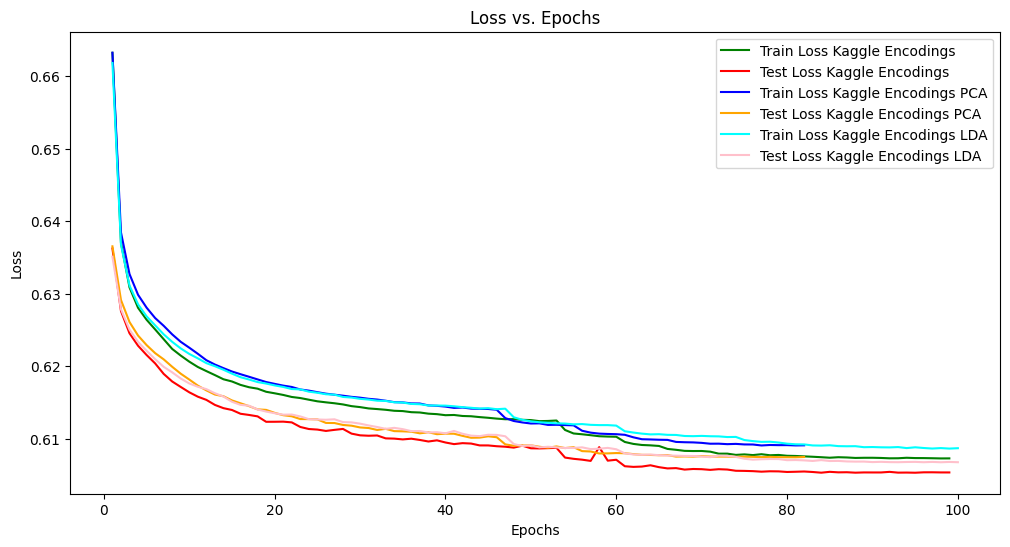

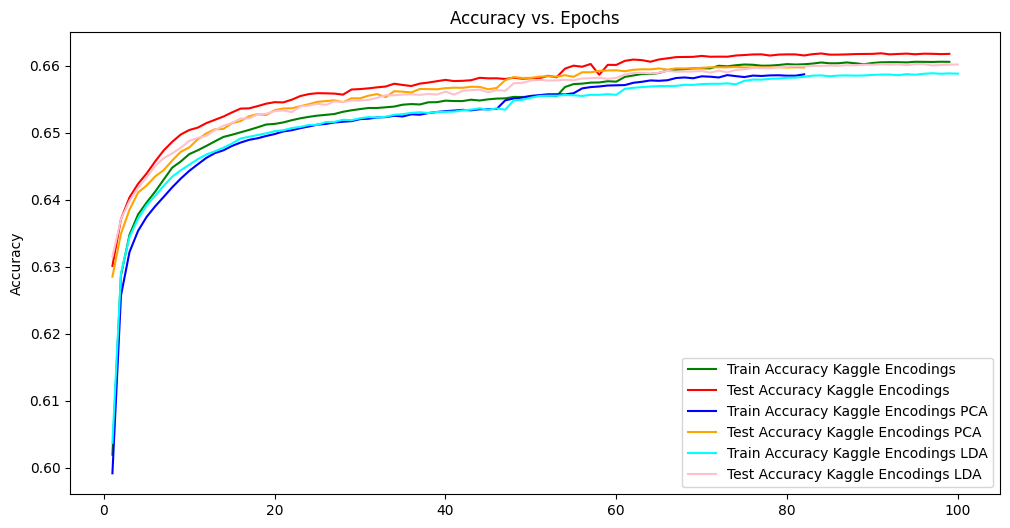

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Plotting function
plt.figure(figsize=(12, 6))
plt.plot(np.arange(1, len(train_loss_kagenc) + 1), train_loss_kagenc, label='Train Loss Kaggle Encodings', color='green')
plt.plot(np.arange(1, len(test_loss_kagenc) + 1), test_loss_kagenc, label='Test Loss Kaggle Encodings', color='red')
plt.plot(np.arange(1, len(train_loss_kagenc_pca) + 1), train_loss_kagenc_pca, label='Train Loss Kaggle Encodings PCA', color='blue')
plt.plot(np.arange(1, len(test_loss_kagenc_pca) + 1), test_loss_kagenc_pca, label='Test Loss Kaggle Encodings PCA', color='orange')
plt.plot(np.arange(1, len(train_loss_kagenc_lda) + 1), train_loss_kagenc_lda, label='Train Loss Kaggle Encodings LDA', color='cyan')
plt.plot(np.arange(1, len(test_loss_kagenc_lda) + 1), test_loss_kagenc_lda, label='Test Loss Kaggle Encodings LDA', color='pink')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs. Epochs')
plt.legend()
plt.show()

# Plotting function for accuracy
plt.figure(figsize=(12, 6))
plt.plot(np.arange(1, len(train_accuracy_kagenc) + 1), train_accuracy_kagenc, label='Train Accuracy Kaggle Encodings', color='green')
plt.plot(np.arange(1, len(test_accuracy_kagenc) + 1), test_accuracy_kagenc, label='Test Accuracy Kaggle Encodings', color='red')
plt.plot(np.arange(1, len(train_accuracy_kagenc_pca) + 1), train_accuracy_kagenc_pca, label='Train Accuracy Kaggle Encodings PCA', color='blue')   
plt.plot(np.arange(1, len(test_accuracy_kagenc_pca) + 1), test_accuracy_kagenc_pca, label='Test Accuracy Kaggle Encodings PCA', color='orange')
plt.plot(np.arange(1, len(train_accuracy_kagenc_lda) + 1), train_accuracy_kagenc_lda, label='Train Accuracy Kaggle Encodings LDA', color='cyan')   
plt.plot(np.arange(1, len(test_accuracy_kagenc_lda) + 1), test_accuracy_kagenc_lda, label='Test Accuracy Kaggle Encodings LDA', color='pink')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epochs')
plt.legend()
plt.show()

## Perform K-Fold Cross Validation

Using mps device
FOLD 1/5
----------------------------------------
Training on mps


Epoch 1/20 - LR: 0.000100: 100%|██████████████████████████████| 2788/2788 [01:56<00:00, 23.97it/s, acc=61.69%, loss=0.6455]


Epoch 1 Loss: 0.6664, Train Accuracy: 59.87%
Test Loss: 0.6394, Test Accuracy: 62.72%


Epoch 2/20 - LR: 0.000100: 100%|██████████████████████████████| 2788/2788 [01:48<00:00, 25.62it/s, acc=61.99%, loss=0.6476]


Epoch 2 Loss: 0.6403, Train Accuracy: 62.51%
Test Loss: 0.6296, Test Accuracy: 63.58%


Epoch 3/20 - LR: 0.000100: 100%|██████████████████████████████| 2788/2788 [01:48<00:00, 25.67it/s, acc=62.55%, loss=0.6295]


Epoch 3 Loss: 0.6331, Train Accuracy: 63.24%
Test Loss: 0.6258, Test Accuracy: 63.92%


Epoch 4/20 - LR: 0.000100: 100%|██████████████████████████████| 2788/2788 [01:50<00:00, 25.12it/s, acc=64.53%, loss=0.6221]


Epoch 4 Loss: 0.6300, Train Accuracy: 63.54%
Test Loss: 0.6240, Test Accuracy: 64.16%


Epoch 5/20 - LR: 0.000100: 100%|██████████████████████████████| 2788/2788 [01:49<00:00, 25.41it/s, acc=63.72%, loss=0.6271]


Epoch 5 Loss: 0.6280, Train Accuracy: 63.77%
Test Loss: 0.6228, Test Accuracy: 64.28%


Epoch 6/20 - LR: 0.000100: 100%|██████████████████████████████| 2788/2788 [01:50<00:00, 25.20it/s, acc=63.36%, loss=0.6334]


Epoch 6 Loss: 0.6266, Train Accuracy: 63.94%
Test Loss: 0.6217, Test Accuracy: 64.42%


Epoch 7/20 - LR: 0.000100: 100%|██████████████████████████████| 2788/2788 [01:49<00:00, 25.46it/s, acc=64.02%, loss=0.6241]


Epoch 7 Loss: 0.6255, Train Accuracy: 64.06%
Test Loss: 0.6210, Test Accuracy: 64.48%


Epoch 8/20 - LR: 0.000100: 100%|██████████████████████████████| 2788/2788 [01:48<00:00, 25.69it/s, acc=65.75%, loss=0.6127]


Epoch 8 Loss: 0.6246, Train Accuracy: 64.19%
Test Loss: 0.6201, Test Accuracy: 64.61%


Epoch 9/20 - LR: 0.000100: 100%|██████████████████████████████| 2788/2788 [01:50<00:00, 25.33it/s, acc=63.62%, loss=0.6248]


Epoch 9 Loss: 0.6237, Train Accuracy: 64.28%
Test Loss: 0.6193, Test Accuracy: 64.71%


Epoch 10/20 - LR: 0.000100: 100%|█████████████████████████████| 2788/2788 [01:49<00:00, 25.37it/s, acc=62.55%, loss=0.6394]


Epoch 10 Loss: 0.6227, Train Accuracy: 64.39%
Test Loss: 0.6184, Test Accuracy: 64.82%


Epoch 11/20 - LR: 0.000100: 100%|█████████████████████████████| 2788/2788 [01:50<00:00, 25.28it/s, acc=64.08%, loss=0.6298]


Epoch 11 Loss: 0.6220, Train Accuracy: 64.49%
Test Loss: 0.6178, Test Accuracy: 64.92%


Epoch 12/20 - LR: 0.000100: 100%|█████████████████████████████| 2788/2788 [01:50<00:00, 25.21it/s, acc=66.26%, loss=0.6159]


Epoch 12 Loss: 0.6213, Train Accuracy: 64.59%
Test Loss: 0.6173, Test Accuracy: 64.97%


Epoch 13/20 - LR: 0.000100: 100%|█████████████████████████████| 2788/2788 [01:49<00:00, 25.45it/s, acc=64.68%, loss=0.6098]


Epoch 13 Loss: 0.6206, Train Accuracy: 64.65%
Test Loss: 0.6167, Test Accuracy: 65.03%


Epoch 14/20 - LR: 0.000100: 100%|█████████████████████████████| 2788/2788 [01:50<00:00, 25.30it/s, acc=65.50%, loss=0.6187]


Epoch 14 Loss: 0.6200, Train Accuracy: 64.73%
Test Loss: 0.6163, Test Accuracy: 65.09%


Epoch 15/20 - LR: 0.000100: 100%|█████████████████████████████| 2788/2788 [01:50<00:00, 25.19it/s, acc=64.43%, loss=0.6254]


Epoch 15 Loss: 0.6195, Train Accuracy: 64.77%
Test Loss: 0.6157, Test Accuracy: 65.14%


Epoch 16/20 - LR: 0.000100: 100%|█████████████████████████████| 2788/2788 [01:49<00:00, 25.37it/s, acc=64.48%, loss=0.6292]


Epoch 16 Loss: 0.6189, Train Accuracy: 64.85%
Test Loss: 0.6151, Test Accuracy: 65.20%


Epoch 17/20 - LR: 0.000100: 100%|█████████████████████████████| 2788/2788 [01:50<00:00, 25.13it/s, acc=65.29%, loss=0.6226]


Epoch 17 Loss: 0.6185, Train Accuracy: 64.92%
Test Loss: 0.6147, Test Accuracy: 65.23%


Epoch 18/20 - LR: 0.000100: 100%|█████████████████████████████| 2788/2788 [01:49<00:00, 25.44it/s, acc=65.55%, loss=0.6181]


Epoch 18 Loss: 0.6182, Train Accuracy: 64.96%
Test Loss: 0.6143, Test Accuracy: 65.29%


Epoch 19/20 - LR: 0.000100: 100%|█████████████████████████████| 2788/2788 [01:50<00:00, 25.16it/s, acc=65.75%, loss=0.6132]


Epoch 19 Loss: 0.6178, Train Accuracy: 64.98%
Test Loss: 0.6143, Test Accuracy: 65.33%


Epoch 20/20 - LR: 0.000100: 100%|█████████████████████████████| 2788/2788 [01:51<00:00, 25.05it/s, acc=64.28%, loss=0.6218]


Epoch 20 Loss: 0.6175, Train Accuracy: 65.03%
Test Loss: 0.6139, Test Accuracy: 65.34%
Fold 1 - Training Loss: 0.6175, Validation Loss: 0.6139
Fold 1 - Training Accuracy: 0.6503, Validation Accuracy: 0.6534
----------------------------------------
FOLD 2/5
----------------------------------------
Training on mps


Epoch 1/20 - LR: 0.000100: 100%|██████████████████████████████| 2788/2788 [01:56<00:00, 23.84it/s, acc=60.03%, loss=0.6545]


Epoch 1 Loss: 0.6658, Train Accuracy: 59.91%
Test Loss: 0.6393, Test Accuracy: 62.77%


Epoch 2/20 - LR: 0.000100: 100%|██████████████████████████████| 2788/2788 [02:03<00:00, 22.51it/s, acc=61.76%, loss=0.6448]


Epoch 2 Loss: 0.6399, Train Accuracy: 62.58%
Test Loss: 0.6295, Test Accuracy: 63.63%


Epoch 3/20 - LR: 0.000100: 100%|██████████████████████████████| 2788/2788 [01:54<00:00, 24.26it/s, acc=61.50%, loss=0.6419]


Epoch 3 Loss: 0.6329, Train Accuracy: 63.31%
Test Loss: 0.6259, Test Accuracy: 63.91%


Epoch 4/20 - LR: 0.000100: 100%|██████████████████████████████| 2788/2788 [01:56<00:00, 23.97it/s, acc=63.74%, loss=0.6250]


Epoch 4 Loss: 0.6297, Train Accuracy: 63.63%
Test Loss: 0.6238, Test Accuracy: 64.16%


Epoch 5/20 - LR: 0.000100: 100%|██████████████████████████████| 2788/2788 [02:07<00:00, 21.89it/s, acc=63.18%, loss=0.6400]


Epoch 5 Loss: 0.6277, Train Accuracy: 63.85%
Test Loss: 0.6226, Test Accuracy: 64.30%


Epoch 6/20 - LR: 0.000100: 100%|██████████████████████████████| 2788/2788 [02:02<00:00, 22.78it/s, acc=64.50%, loss=0.6143]


Epoch 6 Loss: 0.6264, Train Accuracy: 63.98%
Test Loss: 0.6217, Test Accuracy: 64.42%


Epoch 7/20 - LR: 0.000100: 100%|██████████████████████████████| 2788/2788 [02:03<00:00, 22.62it/s, acc=63.48%, loss=0.6200]


Epoch 7 Loss: 0.6252, Train Accuracy: 64.10%
Test Loss: 0.6206, Test Accuracy: 64.56%


Epoch 8/20 - LR: 0.000100: 100%|██████████████████████████████| 2788/2788 [02:05<00:00, 22.17it/s, acc=63.33%, loss=0.6287]


Epoch 8 Loss: 0.6242, Train Accuracy: 64.23%
Test Loss: 0.6197, Test Accuracy: 64.65%


Epoch 9/20 - LR: 0.000100: 100%|██████████████████████████████| 2788/2788 [02:06<00:00, 22.03it/s, acc=63.38%, loss=0.6395]


Epoch 9 Loss: 0.6233, Train Accuracy: 64.33%
Test Loss: 0.6189, Test Accuracy: 64.75%


Epoch 10/20 - LR: 0.000100: 100%|█████████████████████████████| 2788/2788 [02:04<00:00, 22.35it/s, acc=65.82%, loss=0.6156]


Epoch 10 Loss: 0.6225, Train Accuracy: 64.45%
Test Loss: 0.6183, Test Accuracy: 64.82%


Epoch 11/20 - LR: 0.000100: 100%|█████████████████████████████| 2788/2788 [02:05<00:00, 22.24it/s, acc=63.38%, loss=0.6312]


Epoch 11 Loss: 0.6217, Train Accuracy: 64.56%
Test Loss: 0.6177, Test Accuracy: 64.89%


Epoch 12/20 - LR: 0.000100: 100%|█████████████████████████████| 2788/2788 [02:03<00:00, 22.60it/s, acc=63.43%, loss=0.6284]


Epoch 12 Loss: 0.6211, Train Accuracy: 64.61%
Test Loss: 0.6171, Test Accuracy: 64.95%


Epoch 13/20 - LR: 0.000100: 100%|█████████████████████████████| 2788/2788 [02:02<00:00, 22.80it/s, acc=64.40%, loss=0.6191]


Epoch 13 Loss: 0.6204, Train Accuracy: 64.68%
Test Loss: 0.6167, Test Accuracy: 64.99%


Epoch 14/20 - LR: 0.000100: 100%|█████████████████████████████| 2788/2788 [02:05<00:00, 22.26it/s, acc=64.80%, loss=0.6154]


Epoch 14 Loss: 0.6199, Train Accuracy: 64.74%
Test Loss: 0.6164, Test Accuracy: 65.07%


Epoch 15/20 - LR: 0.000100: 100%|█████████████████████████████| 2788/2788 [02:02<00:00, 22.79it/s, acc=66.48%, loss=0.6162]


Epoch 15 Loss: 0.6194, Train Accuracy: 64.77%
Test Loss: 0.6157, Test Accuracy: 65.12%


Epoch 16/20 - LR: 0.000100: 100%|█████████████████████████████| 2788/2788 [02:06<00:00, 21.97it/s, acc=65.52%, loss=0.6191]


Epoch 16 Loss: 0.6190, Train Accuracy: 64.86%
Test Loss: 0.6152, Test Accuracy: 65.19%


Epoch 17/20 - LR: 0.000100: 100%|█████████████████████████████| 2788/2788 [02:03<00:00, 22.61it/s, acc=64.45%, loss=0.6245]


Epoch 17 Loss: 0.6184, Train Accuracy: 64.92%
Test Loss: 0.6149, Test Accuracy: 65.20%


Epoch 18/20 - LR: 0.000100: 100%|█████████████████████████████| 2788/2788 [02:06<00:00, 22.09it/s, acc=66.33%, loss=0.6105]


Epoch 18 Loss: 0.6181, Train Accuracy: 64.96%
Test Loss: 0.6145, Test Accuracy: 65.23%


Epoch 19/20 - LR: 0.000100: 100%|█████████████████████████████| 2788/2788 [02:08<00:00, 21.63it/s, acc=63.23%, loss=0.6245]


Epoch 19 Loss: 0.6177, Train Accuracy: 64.98%
Test Loss: 0.6142, Test Accuracy: 65.28%


Epoch 20/20 - LR: 0.000100: 100%|█████████████████████████████| 2788/2788 [02:03<00:00, 22.66it/s, acc=66.23%, loss=0.6080]


Epoch 20 Loss: 0.6173, Train Accuracy: 65.03%
Test Loss: 0.6139, Test Accuracy: 65.30%
Fold 2 - Training Loss: 0.6173, Validation Loss: 0.6139
Fold 2 - Training Accuracy: 0.6503, Validation Accuracy: 0.6530
----------------------------------------
FOLD 3/5
----------------------------------------
Training on mps


Epoch 1/20 - LR: 0.000100: 100%|██████████████████████████████| 2788/2788 [02:04<00:00, 22.45it/s, acc=59.12%, loss=0.6634]


Epoch 1 Loss: 0.6646, Train Accuracy: 60.02%
Test Loss: 0.6379, Test Accuracy: 62.83%


Epoch 2/20 - LR: 0.000100: 100%|██████████████████████████████| 2788/2788 [02:03<00:00, 22.55it/s, acc=62.77%, loss=0.6311]


Epoch 2 Loss: 0.6396, Train Accuracy: 62.60%
Test Loss: 0.6290, Test Accuracy: 63.61%


Epoch 3/20 - LR: 0.000100: 100%|██████████████████████████████| 2788/2788 [02:03<00:00, 22.59it/s, acc=62.16%, loss=0.6549]


Epoch 3 Loss: 0.6327, Train Accuracy: 63.30%
Test Loss: 0.6252, Test Accuracy: 63.97%


Epoch 4/20 - LR: 0.000100: 100%|██████████████████████████████| 2788/2788 [02:06<00:00, 22.02it/s, acc=62.21%, loss=0.6440]


Epoch 4 Loss: 0.6296, Train Accuracy: 63.61%
Test Loss: 0.6235, Test Accuracy: 64.16%


Epoch 5/20 - LR: 0.000100: 100%|██████████████████████████████| 2788/2788 [02:03<00:00, 22.51it/s, acc=64.30%, loss=0.6230]


Epoch 5 Loss: 0.6278, Train Accuracy: 63.79%
Test Loss: 0.6222, Test Accuracy: 64.28%


Epoch 6/20 - LR: 0.000100: 100%|██████████████████████████████| 2788/2788 [02:06<00:00, 22.05it/s, acc=62.82%, loss=0.6249]


Epoch 6 Loss: 0.6266, Train Accuracy: 63.95%
Test Loss: 0.6213, Test Accuracy: 64.43%


Epoch 7/20 - LR: 0.000100: 100%|██████████████████████████████| 2788/2788 [02:06<00:00, 22.04it/s, acc=64.55%, loss=0.6170]


Epoch 7 Loss: 0.6253, Train Accuracy: 64.10%
Test Loss: 0.6203, Test Accuracy: 64.56%


Epoch 8/20 - LR: 0.000100: 100%|██████████████████████████████| 2788/2788 [02:06<00:00, 22.08it/s, acc=65.21%, loss=0.6220]


Epoch 8 Loss: 0.6243, Train Accuracy: 64.22%
Test Loss: 0.6193, Test Accuracy: 64.66%


Epoch 9/20 - LR: 0.000100: 100%|██████████████████████████████| 2788/2788 [02:05<00:00, 22.21it/s, acc=63.79%, loss=0.6322]


Epoch 9 Loss: 0.6234, Train Accuracy: 64.34%
Test Loss: 0.6186, Test Accuracy: 64.77%


Epoch 10/20 - LR: 0.000100: 100%|█████████████████████████████| 2788/2788 [02:05<00:00, 22.22it/s, acc=63.08%, loss=0.6289]


Epoch 10 Loss: 0.6226, Train Accuracy: 64.44%
Test Loss: 0.6177, Test Accuracy: 64.89%


Epoch 11/20 - LR: 0.000100: 100%|█████████████████████████████| 2788/2788 [02:06<00:00, 22.05it/s, acc=64.45%, loss=0.6260]


Epoch 11 Loss: 0.6219, Train Accuracy: 64.52%
Test Loss: 0.6173, Test Accuracy: 64.97%


Epoch 12/20 - LR: 0.000100: 100%|█████████████████████████████| 2788/2788 [02:05<00:00, 22.14it/s, acc=65.41%, loss=0.6067]


Epoch 12 Loss: 0.6211, Train Accuracy: 64.62%
Test Loss: 0.6162, Test Accuracy: 65.06%


Epoch 13/20 - LR: 0.000100: 100%|█████████████████████████████| 2788/2788 [02:06<00:00, 21.96it/s, acc=65.36%, loss=0.6252]


Epoch 13 Loss: 0.6204, Train Accuracy: 64.69%
Test Loss: 0.6158, Test Accuracy: 65.10%


Epoch 14/20 - LR: 0.000100: 100%|█████████████████████████████| 2788/2788 [02:06<00:00, 21.98it/s, acc=64.14%, loss=0.6211]


Epoch 14 Loss: 0.6198, Train Accuracy: 64.75%
Test Loss: 0.6152, Test Accuracy: 65.18%


Epoch 15/20 - LR: 0.000100: 100%|█████████████████████████████| 2788/2788 [02:06<00:00, 22.11it/s, acc=64.86%, loss=0.6182]


Epoch 15 Loss: 0.6193, Train Accuracy: 64.83%
Test Loss: 0.6149, Test Accuracy: 65.23%


Epoch 16/20 - LR: 0.000100: 100%|█████████████████████████████| 2788/2788 [02:06<00:00, 22.03it/s, acc=63.89%, loss=0.6220]


Epoch 16 Loss: 0.6188, Train Accuracy: 64.86%
Test Loss: 0.6145, Test Accuracy: 65.22%


Epoch 17/20 - LR: 0.000100: 100%|█████████████████████████████| 2788/2788 [02:06<00:00, 22.00it/s, acc=62.06%, loss=0.6246]


Epoch 17 Loss: 0.6184, Train Accuracy: 64.90%
Test Loss: 0.6141, Test Accuracy: 65.29%


Epoch 18/20 - LR: 0.000100: 100%|█████████████████████████████| 2788/2788 [02:06<00:00, 22.00it/s, acc=64.30%, loss=0.6245]


Epoch 18 Loss: 0.6181, Train Accuracy: 64.93%
Test Loss: 0.6139, Test Accuracy: 65.30%


Epoch 19/20 - LR: 0.000100: 100%|█████████████████████████████| 2788/2788 [02:06<00:00, 22.03it/s, acc=63.89%, loss=0.6218]


Epoch 19 Loss: 0.6178, Train Accuracy: 64.98%
Test Loss: 0.6135, Test Accuracy: 65.34%


Epoch 20/20 - LR: 0.000100: 100%|█████████████████████████████| 2788/2788 [02:08<00:00, 21.70it/s, acc=64.20%, loss=0.6243]


Epoch 20 Loss: 0.6175, Train Accuracy: 65.03%
Test Loss: 0.6131, Test Accuracy: 65.39%
Fold 3 - Training Loss: 0.6175, Validation Loss: 0.6131
Fold 3 - Training Accuracy: 0.6503, Validation Accuracy: 0.6539
----------------------------------------
FOLD 4/5
----------------------------------------
Training on mps


Epoch 1/20 - LR: 0.000100: 100%|██████████████████████████████| 2788/2788 [02:08<00:00, 21.74it/s, acc=61.91%, loss=0.6471]


Epoch 1 Loss: 0.6661, Train Accuracy: 59.91%
Test Loss: 0.6401, Test Accuracy: 62.69%


Epoch 2/20 - LR: 0.000100: 100%|██████████████████████████████| 2788/2788 [02:06<00:00, 22.05it/s, acc=63.38%, loss=0.6326]


Epoch 2 Loss: 0.6405, Train Accuracy: 62.53%
Test Loss: 0.6293, Test Accuracy: 63.61%


Epoch 3/20 - LR: 0.000100: 100%|██████████████████████████████| 2788/2788 [02:07<00:00, 21.88it/s, acc=61.96%, loss=0.6358]


Epoch 3 Loss: 0.6330, Train Accuracy: 63.29%
Test Loss: 0.6256, Test Accuracy: 63.94%


Epoch 4/20 - LR: 0.000100: 100%|██████████████████████████████| 2788/2788 [02:07<00:00, 21.89it/s, acc=63.13%, loss=0.6222]


Epoch 4 Loss: 0.6299, Train Accuracy: 63.60%
Test Loss: 0.6238, Test Accuracy: 64.13%


Epoch 5/20 - LR: 0.000100: 100%|██████████████████████████████| 2788/2788 [02:07<00:00, 21.94it/s, acc=64.65%, loss=0.6304]


Epoch 5 Loss: 0.6281, Train Accuracy: 63.79%
Test Loss: 0.6226, Test Accuracy: 64.27%


Epoch 6/20 - LR: 0.000100: 100%|██████████████████████████████| 2788/2788 [02:07<00:00, 21.80it/s, acc=65.36%, loss=0.6147]


Epoch 6 Loss: 0.6267, Train Accuracy: 63.94%
Test Loss: 0.6217, Test Accuracy: 64.39%


Epoch 7/20 - LR: 0.000100: 100%|██████████████████████████████| 2788/2788 [02:09<00:00, 21.49it/s, acc=63.23%, loss=0.6377]


Epoch 7 Loss: 0.6256, Train Accuracy: 64.07%
Test Loss: 0.6209, Test Accuracy: 64.49%


Epoch 8/20 - LR: 0.000100: 100%|██████████████████████████████| 2788/2788 [02:07<00:00, 21.86it/s, acc=64.30%, loss=0.6264]


Epoch 8 Loss: 0.6246, Train Accuracy: 64.18%
Test Loss: 0.6197, Test Accuracy: 64.62%


Epoch 9/20 - LR: 0.000100: 100%|██████████████████████████████| 2788/2788 [02:06<00:00, 21.99it/s, acc=63.28%, loss=0.6288]


Epoch 9 Loss: 0.6237, Train Accuracy: 64.30%
Test Loss: 0.6190, Test Accuracy: 64.71%


Epoch 10/20 - LR: 0.000100: 100%|█████████████████████████████| 2788/2788 [02:06<00:00, 22.06it/s, acc=66.18%, loss=0.6121]


Epoch 10 Loss: 0.6227, Train Accuracy: 64.42%
Test Loss: 0.6181, Test Accuracy: 64.82%


Epoch 11/20 - LR: 0.000100: 100%|█████████████████████████████| 2788/2788 [02:15<00:00, 20.51it/s, acc=62.37%, loss=0.6447]


Epoch 11 Loss: 0.6219, Train Accuracy: 64.52%
Test Loss: 0.6175, Test Accuracy: 64.92%


Epoch 12/20 - LR: 0.000100: 100%|█████████████████████████████| 2788/2788 [01:49<00:00, 25.46it/s, acc=65.21%, loss=0.6219]


Epoch 12 Loss: 0.6213, Train Accuracy: 64.59%
Test Loss: 0.6169, Test Accuracy: 64.93%


Epoch 13/20 - LR: 0.000100: 100%|█████████████████████████████| 2788/2788 [01:51<00:00, 25.12it/s, acc=64.45%, loss=0.6249]


Epoch 13 Loss: 0.6208, Train Accuracy: 64.65%
Test Loss: 0.6165, Test Accuracy: 64.99%


Epoch 14/20 - LR: 0.000100: 100%|█████████████████████████████| 2788/2788 [01:51<00:00, 25.08it/s, acc=62.62%, loss=0.6414]


Epoch 14 Loss: 0.6202, Train Accuracy: 64.71%
Test Loss: 0.6163, Test Accuracy: 65.02%


Epoch 15/20 - LR: 0.000100: 100%|█████████████████████████████| 2788/2788 [02:06<00:00, 22.09it/s, acc=64.25%, loss=0.6253]


Epoch 15 Loss: 0.6197, Train Accuracy: 64.80%
Test Loss: 0.6157, Test Accuracy: 65.08%


Epoch 16/20 - LR: 0.000100: 100%|█████████████████████████████| 2788/2788 [01:53<00:00, 24.63it/s, acc=62.93%, loss=0.6257]


Epoch 16 Loss: 0.6192, Train Accuracy: 64.83%
Test Loss: 0.6152, Test Accuracy: 65.15%


Epoch 17/20 - LR: 0.000100: 100%|█████████████████████████████| 2788/2788 [01:49<00:00, 25.53it/s, acc=64.09%, loss=0.6152]


Epoch 17 Loss: 0.6188, Train Accuracy: 64.86%
Test Loss: 0.6148, Test Accuracy: 65.17%


Epoch 18/20 - LR: 0.000100: 100%|█████████████████████████████| 2788/2788 [01:49<00:00, 25.36it/s, acc=66.38%, loss=0.6105]


Epoch 18 Loss: 0.6184, Train Accuracy: 64.92%
Test Loss: 0.6145, Test Accuracy: 65.23%


Epoch 19/20 - LR: 0.000100: 100%|█████████████████████████████| 2788/2788 [01:49<00:00, 25.44it/s, acc=64.60%, loss=0.6218]


Epoch 19 Loss: 0.6179, Train Accuracy: 64.96%
Test Loss: 0.6138, Test Accuracy: 65.28%


Epoch 20/20 - LR: 0.000100: 100%|█████████████████████████████| 2788/2788 [01:49<00:00, 25.37it/s, acc=66.63%, loss=0.6122]


Epoch 20 Loss: 0.6175, Train Accuracy: 65.00%
Test Loss: 0.6137, Test Accuracy: 65.31%
Fold 4 - Training Loss: 0.6175, Validation Loss: 0.6137
Fold 4 - Training Accuracy: 0.6500, Validation Accuracy: 0.6531
----------------------------------------
FOLD 5/5
----------------------------------------
Training on mps


Epoch 1/20 - LR: 0.000100: 100%|██████████████████████████████| 2788/2788 [01:49<00:00, 25.37it/s, acc=61.55%, loss=0.6537]


Epoch 1 Loss: 0.6650, Train Accuracy: 60.04%
Test Loss: 0.6385, Test Accuracy: 62.91%


Epoch 2/20 - LR: 0.000100: 100%|██████████████████████████████| 2788/2788 [01:51<00:00, 25.04it/s, acc=61.76%, loss=0.6340]


Epoch 2 Loss: 0.6402, Train Accuracy: 62.57%
Test Loss: 0.6291, Test Accuracy: 63.67%


Epoch 3/20 - LR: 0.000100: 100%|██████████████████████████████| 2788/2788 [01:49<00:00, 25.56it/s, acc=61.91%, loss=0.6320]


Epoch 3 Loss: 0.6331, Train Accuracy: 63.28%
Test Loss: 0.6252, Test Accuracy: 63.98%


Epoch 4/20 - LR: 0.000100: 100%|██████████████████████████████| 2788/2788 [01:49<00:00, 25.39it/s, acc=63.43%, loss=0.6322]


Epoch 4 Loss: 0.6298, Train Accuracy: 63.59%
Test Loss: 0.6235, Test Accuracy: 64.21%


Epoch 5/20 - LR: 0.000100: 100%|██████████████████████████████| 2788/2788 [01:49<00:00, 25.47it/s, acc=63.64%, loss=0.6278]


Epoch 5 Loss: 0.6280, Train Accuracy: 63.78%
Test Loss: 0.6222, Test Accuracy: 64.36%


Epoch 6/20 - LR: 0.000100: 100%|██████████████████████████████| 2788/2788 [01:50<00:00, 25.22it/s, acc=64.20%, loss=0.6236]


Epoch 6 Loss: 0.6266, Train Accuracy: 63.95%
Test Loss: 0.6214, Test Accuracy: 64.43%


Epoch 7/20 - LR: 0.000100: 100%|██████████████████████████████| 2788/2788 [01:49<00:00, 25.39it/s, acc=64.55%, loss=0.6194]


Epoch 7 Loss: 0.6254, Train Accuracy: 64.07%
Test Loss: 0.6202, Test Accuracy: 64.58%


Epoch 8/20 - LR: 0.000100: 100%|██████████████████████████████| 2788/2788 [01:50<00:00, 25.18it/s, acc=63.33%, loss=0.6257]


Epoch 8 Loss: 0.6245, Train Accuracy: 64.18%
Test Loss: 0.6195, Test Accuracy: 64.67%


Epoch 9/20 - LR: 0.000100: 100%|██████████████████████████████| 2788/2788 [01:49<00:00, 25.54it/s, acc=64.50%, loss=0.6199]


Epoch 9 Loss: 0.6236, Train Accuracy: 64.28%
Test Loss: 0.6188, Test Accuracy: 64.80%


Epoch 10/20 - LR: 0.000100: 100%|█████████████████████████████| 2788/2788 [01:49<00:00, 25.45it/s, acc=66.38%, loss=0.6154]


Epoch 10 Loss: 0.6227, Train Accuracy: 64.41%
Test Loss: 0.6179, Test Accuracy: 64.86%


Epoch 11/20 - LR: 0.000100: 100%|█████████████████████████████| 2788/2788 [01:50<00:00, 25.21it/s, acc=64.35%, loss=0.6117]


Epoch 11 Loss: 0.6219, Train Accuracy: 64.52%
Test Loss: 0.6172, Test Accuracy: 64.92%


Epoch 12/20 - LR: 0.000100: 100%|█████████████████████████████| 2788/2788 [01:49<00:00, 25.46it/s, acc=66.28%, loss=0.6124]


Epoch 12 Loss: 0.6212, Train Accuracy: 64.60%
Test Loss: 0.6168, Test Accuracy: 64.98%


Epoch 13/20 - LR: 0.000100: 100%|█████████████████████████████| 2788/2788 [01:52<00:00, 24.84it/s, acc=61.86%, loss=0.6442]


Epoch 13 Loss: 0.6205, Train Accuracy: 64.67%
Test Loss: 0.6163, Test Accuracy: 65.04%


Epoch 14/20 - LR: 0.000100: 100%|█████████████████████████████| 2788/2788 [01:50<00:00, 25.32it/s, acc=65.67%, loss=0.6170]


Epoch 14 Loss: 0.6201, Train Accuracy: 64.71%
Test Loss: 0.6160, Test Accuracy: 65.08%


Epoch 15/20 - LR: 0.000100: 100%|█████████████████████████████| 2788/2788 [01:51<00:00, 25.01it/s, acc=65.01%, loss=0.6153]


Epoch 15 Loss: 0.6196, Train Accuracy: 64.79%
Test Loss: 0.6155, Test Accuracy: 65.15%


Epoch 16/20 - LR: 0.000100: 100%|█████████████████████████████| 2788/2788 [01:54<00:00, 24.39it/s, acc=66.33%, loss=0.6068]


Epoch 16 Loss: 0.6192, Train Accuracy: 64.81%
Test Loss: 0.6150, Test Accuracy: 65.19%


Epoch 17/20 - LR: 0.000100: 100%|█████████████████████████████| 2788/2788 [01:53<00:00, 24.56it/s, acc=64.70%, loss=0.6111]


Epoch 17 Loss: 0.6189, Train Accuracy: 64.85%
Test Loss: 0.6147, Test Accuracy: 65.20%


Epoch 18/20 - LR: 0.000100: 100%|█████████████████████████████| 2788/2788 [01:51<00:00, 24.94it/s, acc=65.77%, loss=0.6049]


Epoch 18 Loss: 0.6185, Train Accuracy: 64.90%
Test Loss: 0.6145, Test Accuracy: 65.24%


Epoch 19/20 - LR: 0.000100: 100%|█████████████████████████████| 2788/2788 [01:53<00:00, 24.60it/s, acc=65.57%, loss=0.6117]


Epoch 19 Loss: 0.6181, Train Accuracy: 64.93%
Test Loss: 0.6143, Test Accuracy: 65.24%


Epoch 20/20 - LR: 0.000100: 100%|█████████████████████████████| 2788/2788 [01:49<00:00, 25.43it/s, acc=65.52%, loss=0.6166]


Epoch 20 Loss: 0.6179, Train Accuracy: 64.98%
Test Loss: 0.6138, Test Accuracy: 65.31%
Fold 5 - Training Loss: 0.6179, Validation Loss: 0.6138
Fold 5 - Training Accuracy: 0.6498, Validation Accuracy: 0.6531
----------------------------------------
Average Train Loss: 0.6175
Average Validation Loss: 0.6137
Average Train Accuracy: 0.6501
Average Validation Accuracy: 0.6533


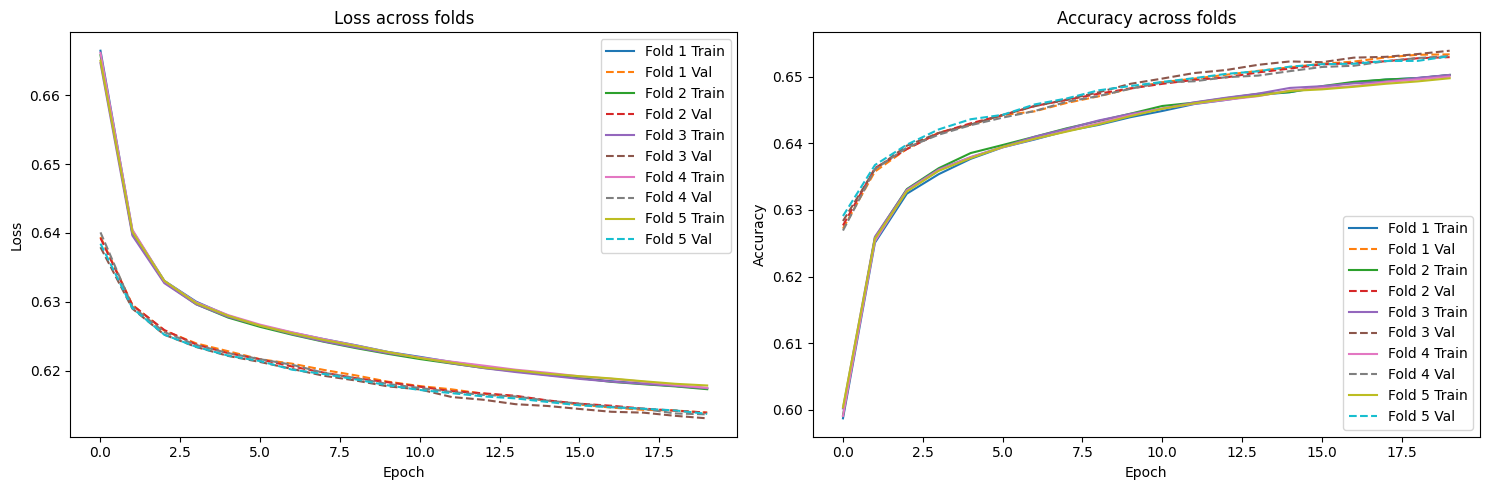

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from tqdm import tqdm
from torch.utils.data import DataLoader, TensorDataset, SubsetRandomSampler
from sklearn.model_selection import KFold
import helper_functions
import importlib
import os

train_dtypes = test_dtypes = dtypes = {
    'ProductName':                                                  'float32',
    'IsBeta':                                                       'float32',
    'RtpStateBitfield':                                             'float32',
    'IsSxsPassiveMode':                                             'float32',
    'DefaultBrowsersIdentifier':                                    'float32',
    'AVProductStatesIdentifier':                                    'float32',
    'AVProductsInstalled':                                          'float32',
    'AVProductsEnabled':                                            'float32',
    'HasTpm':                                                       'float32',
    'CountryIdentifier':                                            'float32',
    'CityIdentifier':                                               'float32',
    'OrganizationIdentifier':                                       'float32',
    'GeoNameIdentifier':                                            'float32',
    'LocaleEnglishNameIdentifier':                                  'float32',
    'Platform':                                                     'float32',
    'Processor':                                                    'float32',
    'OsVer':                                                        'float32',
    'OsBuild':                                                      'float32',
    'OsSuite':                                                      'float32',
    'OsPlatformSubRelease':                                         'float32',
    'OsBuildLab':                                                   'float32',
    'SkuEdition':                                                   'float32',
    'IsProtected':                                                  'float32',
    'AutoSampleOptIn':                                              'float32',
    'PuaMode':                                                      'float32',
    'SMode':                                                        'float32',
    'IeVerIdentifier':                                              'float32',
    'SmartScreen':                                                  'float32',
    'Firewall':                                                     'float32',
    'UacLuaenable':                                                 'float32',
    'Census_MDC2FormFactor':                                        'float32',
    'Census_DeviceFamily':                                          'float32',
    'Census_OEMNameIdentifier':                                     'float32',
    'Census_OEMModelIdentifier':                                    'float32',
    'Census_ProcessorCoreCount':                                    'float32',
    'Census_ProcessorManufacturerIdentifier':                       'float32',
    'Census_ProcessorModelIdentifier':                              'float32',
    'Census_ProcessorClass':                                        'float32',
    'Census_PrimaryDiskTotalCapacity':                              'float32',
    'Census_PrimaryDiskTypeName':                                   'float32',
    'Census_SystemVolumeTotalCapacity':                             'float32',
    'Census_HasOpticalDiskDrive':                                   'float32',
    'Census_TotalPhysicalRAM':                                      'float32',
    'Census_ChassisTypeName':                                       'float32',
    'Census_InternalPrimaryDiagonalDisplaySizeInInches':            'float32',
    'Census_InternalPrimaryDisplayResolutionHorizontal':            'float32',
    'Census_InternalPrimaryDisplayResolutionVertical':              'float32',
    'Census_PowerPlatformRoleName':                                 'float32',
    'Census_InternalBatteryType':                                   'float32',
    'Census_InternalBatteryNumberOfCharges':                        'float32',
    'Census_OSArchitecture':                                        'float32',
    'Census_OSBranch':                                              'float32',
    'Census_OSBuildNumber':                                         'float32',
    'Census_OSBuildRevision':                                       'float32',
    'Census_OSEdition':                                             'float32',
    'Census_OSSkuName':                                             'float32',
    'Census_OSInstallTypeName':                                     'float32',
    'Census_OSInstallLanguageIdentifier':                           'float32',
    'Census_OSUILocaleIdentifier':                                  'float32',
    'Census_OSWUAutoUpdateOptionsName':                             'float32',
    'Census_IsPortableOperatingSystem':                             'float32',
    'Census_GenuineStateName':                                      'float32',
    'Census_ActivationChannel':                                     'float32',
    'Census_IsFlightingInternal':                                   'float32',
    'Census_IsFlightsDisabled':                                     'float32',
    'Census_FlightRing':                                            'float32',
    'Census_ThresholdOptIn':                                        'float32',
    'Census_FirmwareManufacturerIdentifier':                        'float32',
    'Census_FirmwareVersionIdentifier':                             'float32',
    'Census_IsSecureBootEnabled':                                   'float32',
    'Census_IsWIMBootEnabled':                                      'float32',
    'Census_IsVirtualDevice':                                       'float32',
    'Census_IsTouchEnabled':                                        'float32',
    'Census_IsPenCapable':                                          'float32',
    'Census_IsAlwaysOnAlwaysConnectedCapable':                      'float32',
    'Wdft_IsGamer':                                                 'float32',
    'Wdft_RegionIdentifier':                                        'float32',
    'EngineVersion_1':                                              'int8',
    'EngineVersion_2':                                              'int8',
    'EngineVersion_3':                                              'float32',
    'EngineVersion_4':                                              'float32',
    'AppVersion_1':                                                 'int8',
    'AppVersion_2':                                                 'float32',
    'AppVersion_3':                                                 'float32',
    'AppVersion_4':                                                 'float32',
    'AvSigVersion_1':                                               'float32',
    'AvSigVersion_2':                                               'float32',
    'AvSigVersion_3':                                               'float32',
    'AvSigVersion_4':                                               'int8',
    'Census_OSVersion_1':                                           'float32',
    'Census_OSVersion_2':                                           'float32',
    'Census_OSVersion_3':                                           'float32',
    'Census_OSVersion_4':                                           'float32',
    'HasDetections':                                                'int8',
}

train_data = pd.read_csv("../data/train_data_kaggle_processed.csv", dtype=train_dtypes)
test_data = pd.read_csv("../data/validation_data_kaggle_processed.csv", dtype=test_dtypes)

X_train = train_data.drop('HasDetections', axis=1)
y_train = train_data['HasDetections']
X_valid = test_data.drop('HasDetections', axis=1)
y_valid = test_data['HasDetections']

del train_data, test_data

# Convert to tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_valid_tensor = torch.tensor(X_valid.values, dtype=torch.float32)
y_valid_tensor = torch.tensor(y_valid.values, dtype=torch.float32).view(-1, 1)

# Figure out which device to use
device = "cpu"
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
print(f"Using {device} device")

# Define model architecture (same as yours)
class BinaryClassifier(nn.Module):
    def __init__(self, input_dim):
        super(BinaryClassifier, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.3),

            nn.Linear(512, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.3),

            nn.Linear(256, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.4),

            nn.Linear(128, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.4),

            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.layers(x)

# K-Fold implementation
def run_kfold_cross_validation(X, y, k=5, batch_size=2048, epochs=10):
    # Combine data for K-fold
    dataset = TensorDataset(X, y)
    
    # Define the K-fold Cross Validator
    kfold = KFold(n_splits=k, shuffle=True, random_state=42)
    
    # For storing fold results
    fold_results = {
        'train_losses': [],
        'val_losses': [],
        'train_accuracies': [],
        'val_accuracies': [],
    }
    
    # K-fold Cross Validation
    for fold, (train_ids, val_ids) in enumerate(kfold.split(X)):
        print(f'FOLD {fold+1}/{k}')
        print('-' * 40)
        
        # Sample elements randomly from a given list of ids, no replacement
        train_sampler = SubsetRandomSampler(train_ids)
        val_sampler = SubsetRandomSampler(val_ids)
        
        # Define data loaders for training and validation
        train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
        val_loader = DataLoader(dataset, batch_size=batch_size, sampler=val_sampler)
        
        # Initialize model, criterion, optimizer
        model = BinaryClassifier(X.shape[1]).to(device)
        criterion = nn.BCEWithLogitsLoss()
        optimizer = optim.Adam(model.parameters(), weight_decay=1e-4, lr=0.0001)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)
        
        # Train and evaluate for this fold
        best_model_weights, train_loss, val_loss, train_acc, val_acc, lrs = helper_functions.train_and_evaluate_model(
            model, criterion, optimizer, scheduler, train_loader, val_loader, epochs=epochs
        )
        
        # Store fold results
        fold_results['train_losses'].append(train_loss)
        fold_results['val_losses'].append(val_loss)
        fold_results['train_accuracies'].append(train_acc)
        fold_results['val_accuracies'].append(val_acc)
        
        # Save the model for this fold
        torch.save(model.state_dict(), f'deepernn_kaggle_fold_{fold+1}.pth')
        
        print(f'Fold {fold+1} - Training Loss: {train_loss[-1]:.4f}, Validation Loss: {val_loss[-1]:.4f}')
        print(f'Fold {fold+1} - Training Accuracy: {train_acc[-1]:.4f}, Validation Accuracy: {val_acc[-1]:.4f}')
        print('-' * 40)
    
    # Calculate and print average results across all folds
    avg_train_loss = np.mean([losses[-1] for losses in fold_results['train_losses']])
    avg_val_loss = np.mean([losses[-1] for losses in fold_results['val_losses']])
    avg_train_acc = np.mean([acc[-1] for acc in fold_results['train_accuracies']])
    avg_val_acc = np.mean([acc[-1] for acc in fold_results['val_accuracies']])
    
    print(f"Average Train Loss: {avg_train_loss:.4f}")
    print(f"Average Validation Loss: {avg_val_loss:.4f}")
    print(f"Average Train Accuracy: {avg_train_acc:.4f}")
    print(f"Average Validation Accuracy: {avg_val_acc:.4f}")
    
    return fold_results

# Run K-Fold cross validation
k = 5  # Number of folds
num_epochs = 20

# Run K-Fold CV
fold_results = run_kfold_cross_validation(
    X_train_tensor, 
    y_train_tensor, 
    k=k, 
    batch_size=2048, 
    epochs=num_epochs
)

### Plot the K-Fold Runs' Losses and Accuracies

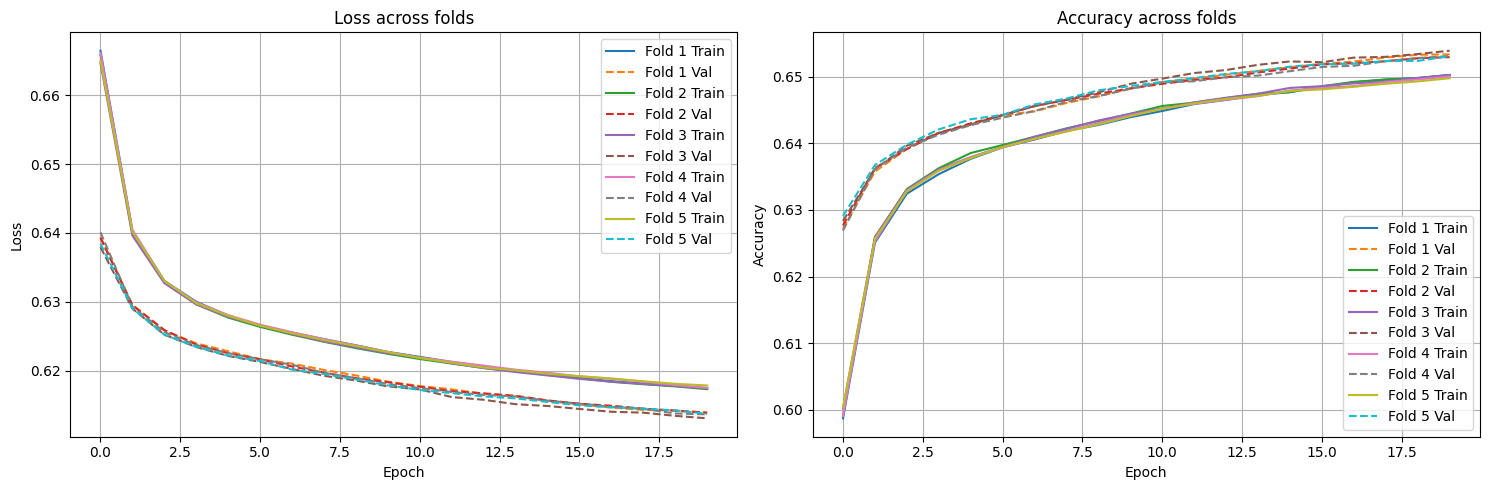

In [8]:
# Function to plot results of K-Fold
def plot_kfold_results(fold_results, k=5):
    import matplotlib.pyplot as plt
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot loss
    for fold in range(k):
        ax1.plot(fold_results['train_losses'][fold], label=f'Fold {fold+1} Train')
        ax1.plot(fold_results['val_losses'][fold], label=f'Fold {fold+1} Val', linestyle='--')
    
    ax1.set_title('Loss across folds')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)
    
    # Plot accuracy
    for fold in range(k):
        ax2.plot(fold_results['train_accuracies'][fold], label=f'Fold {fold+1} Train')
        ax2.plot(fold_results['val_accuracies'][fold], label=f'Fold {fold+1} Val', linestyle='--')
    
    ax2.set_title('Accuracy across folds')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

# Plot the results
plot_kfold_results(fold_results, k=k)